In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from hmmlearn import hmm
import math
from sklearn.metrics import r2_score

In [2]:
dataset = pd.read_csv("GMM_values.csv", header=0)

In [3]:
#get failure times 
failurePoints = []
for index, row in dataset.iterrows():
    current_state = row['State']
    if current_state > 3:
        failurePoints.append(row['Timestep'])

In [4]:
def getRUL(current, failurelst):
    nextFailure = None
    for f in failurelst:
        if f - current >= 0: 
            nextFailure = f
            break 
    if nextFailure != None:
        diff = nextFailure - current 
        return diff
    else: 
        return None

In [5]:
#investigate general trend of RUL values 
total_rul = []
timeX = dataset['Timestep'].tolist()
for instance in timeX:
    current_rul = getRUL(instance, failurePoints)
    total_rul.append(current_rul)

In [6]:
#create a new dataframe with RUL 
all_df = dataset.copy(deep=True)
all_df['RUL'] = total_rul
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7995,7995,0.333491,0.682035,0.220176,0.249060,0,NaN
7996,7996,0.344994,0.689298,0.225088,0.218040,1,NaN
7997,7997,0.390017,0.641338,0.211275,0.239294,1,NaN
7998,7998,0.324577,0.656867,0.205467,0.294698,1,NaN


In [7]:
#drop na columns 
all_df = all_df.dropna()
all_df

,Timestep,Volt,Rotate,Pressure,Vibration,State,RUL
0,0,0.379151,0.556385,0.243080,0.229504,0,9.0
1,1,0.415507,0.698561,0.242410,0.273825,1,8.0
2,2,0.339342,0.637645,0.230266,0.191588,2,7.0
3,3,0.343817,0.627732,0.233905,0.264566,2,6.0
4,4,0.310362,0.607368,0.194296,0.240200,2,5.0
...,...,...,...,...,...,...,...
7987,7987,0.325059,0.616790,0.235959,0.192175,2,4.0
7988,7988,0.388779,0.670864,0.243099,0.248306,2,3.0
7989,7989,0.339885,0.607819,0.237883,0.232814,3,2.0
7990,7990,0.525533,0.611479,0.414174,0.214225,3,1.0


In [8]:
#split data into episodes
data_split = []
chunkBySize = []
for index, row in all_df.iterrows():
    currentRUL = row['RUL']
    arr = [row['Timestep'], row['Volt'], row['Rotate'], row['Pressure'], row['Vibration'], row['RUL'], row['State']]
    if currentRUL < 1:  
        chunkBySize.append(arr)
        if (chunkBySize):
            data_split.append(chunkBySize)
        chunkBySize = []
    else:
        chunkBySize.append(arr)

In [9]:
#split in training, validation and test sets

num_episodes = len(data_split)
num_train = int(0.8*num_episodes)
num_val = int(0.1*num_episodes)

train_data = data_split[:num_train]
val_data = data_split[num_train:num_train+num_val]
test_data = data_split[num_train+num_val:]

In [10]:
train_data

[[[0.0, 0.379151092, 0.556385187, 0.243079506, 0.229504293, 9.0, 0.0],
  [1.0, 0.415506993, 0.698561103, 0.242410288, 0.273824561, 8.0, 1.0],
  [2.0, 0.33934205, 0.637644818, 0.230266358, 0.191588098, 7.0, 2.0],
  [3.0, 0.343817356, 0.627731997, 0.233904513, 0.264566349, 6.0, 2.0],
  [4.0, 0.310361557, 0.607368113, 0.194295643, 0.240200195, 5.0, 2.0],
  [5.0, 0.336327636, 0.531479142, 0.215693485, 0.215780325, 4.0, 2.0],
  [6.0, 0.397831149, 0.57521239, 0.190585546, 0.230599092, 3.0, 2.0],
  [7.0, 0.385974096, 0.630933953, 0.208516333, 0.247693397, 2.0, 2.0],
  [8.0, 0.376943194, 0.396047283, 0.215659658, 0.256992779, 1.0, 3.0],
  [9.0, 0.56498231, 0.648197926, 0.516587151, 0.256162471, 0.0, 4.0]],
 [[10.0, 0.351867147, 0.647795783, 0.257161825, 0.276671218, 12.0, 0.0],
  [11.0, 0.353867353, 0.615858294, 0.197009134, 0.269388231, 11.0, 0.0],
  [12.0, 0.384169823, 0.622861995, 0.199791766, 0.305659257, 10.0, 0.0],
  [13.0, 0.353154082, 0.597895409, 0.2172971, 0.265631153, 9.0, 1.0],
  [

In [11]:
def getStates(data):
    stateList = []
    for episode in data:
        for instance in episode:
            stateList.append(instance[6])
    return stateList

In [12]:
#get state information
trainStates = getStates(train_data)
valStates = getStates(val_data)
testStates = getStates(test_data)

In [13]:
trainStates

[0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 5.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.0,
 3.0,
 4.0,
 0.0,
 1.0,
 2.0,
 2.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 1.0,
 5.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 5.0,
 0.0,
 1.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 1.0,
 1.0,
 2.0,
 3.0,
 4.0,
 0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 4.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.0,
 3.0,
 4.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 5.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0

In [14]:
def getRULValues(data):
    rulList = []
    for episode in data:
        for instance in episode:
            rulList.append(instance[5])
    return rulList

In [15]:
#get rul values
trainRUL = getRULValues(train_data)
valRUL = getRULValues(val_data)
testRUL = getRULValues(test_data)

In [16]:
def getTime(data):
    timeList = []
    for episode in data:
        for instance in episode:
            timeList.append(instance[0])
    return timeList

In [17]:
#get time
trainTime = getTime(train_data)
valTime = getTime(val_data)
testTime = getTime(test_data)

In [18]:
def getEndIndexes(data):
    endIndexList = []
    indexCounter = 0
    for episode in data:
        for instance in episode:
            currentRUL = instance[5]
            if currentRUL < 1:
                endIndexList.append(indexCounter)
            indexCounter += 1
    return endIndexList

In [19]:
trainEndIndexes = getEndIndexes(train_data)
valEndIndexes = getEndIndexes(val_data)
testEndIndexes = getEndIndexes(test_data)

In [20]:
def findSscore(actualRULlist, predictedRULlist):
    Sscore = 0
    for order in range(len(actualRULlist)):
        actualRUL = actualRULlist[order]
        predictedRUL = predictedRULlist[order]
        diff = abs(actualRUL - predictedRUL)
        if predictedRUL < actualRUL: #underestimate
            multiplier = 1/13
        else: #overestimate
            multiplier = 1/10
        factor = multiplier*diff
        score = math.exp(factor)
        Sscore += score
    return Sscore

Create a HMM with 6 states

In [21]:
def getSensorReadingsByEpisode(data):
    output = []
    for episode in data:
        episode_data = []
        for instance in episode:
            reading = instance[1:5]
            episode_data.append(reading)
        output.append(episode_data)
    return output

In [22]:
train_readings = getSensorReadingsByEpisode(train_data)

In [23]:
train_readings

[[[0.379151092, 0.556385187, 0.243079506, 0.229504293],
  [0.415506993, 0.698561103, 0.242410288, 0.273824561],
  [0.33934205, 0.637644818, 0.230266358, 0.191588098],
  [0.343817356, 0.627731997, 0.233904513, 0.264566349],
  [0.310361557, 0.607368113, 0.194295643, 0.240200195],
  [0.336327636, 0.531479142, 0.215693485, 0.215780325],
  [0.397831149, 0.57521239, 0.190585546, 0.230599092],
  [0.385974096, 0.630933953, 0.208516333, 0.247693397],
  [0.376943194, 0.396047283, 0.215659658, 0.256992779],
  [0.56498231, 0.648197926, 0.516587151, 0.256162471]],
 [[0.351867147, 0.647795783, 0.257161825, 0.276671218],
  [0.353867353, 0.615858294, 0.197009134, 0.269388231],
  [0.384169823, 0.622861995, 0.199791766, 0.305659257],
  [0.353154082, 0.597895409, 0.2172971, 0.265631153],
  [0.382126061, 0.655505276, 0.231748822, 0.258702261],
  [0.374770865, 0.676145451, 0.243662648, 0.259956326],
  [0.406003625, 0.626204276, 0.246397078, 0.26882794],
  [0.351261256, 0.265259177, 0.168831064, 0.441434541

In [24]:
train_length = []
for train_episode in train_readings:
    train_length.append(len(train_episode))

In [25]:
train_length

[10,
 13,
 10,
 12,
 6,
 19,
 5,
 9,
 4,
 8,
 6,
 16,
 11,
 9,
 9,
 15,
 13,
 8,
 4,
 14,
 12,
 11,
 12,
 8,
 12,
 6,
 19,
 10,
 28,
 14,
 3,
 19,
 4,
 3,
 8,
 5,
 13,
 14,
 10,
 12,
 15,
 9,
 14,
 9,
 7,
 13,
 19,
 8,
 11,
 23,
 20,
 15,
 11,
 20,
 9,
 4,
 14,
 16,
 10,
 8,
 8,
 8,
 14,
 13,
 19,
 20,
 11,
 10,
 21,
 9,
 11,
 16,
 9,
 14,
 9,
 11,
 14,
 2,
 13,
 9,
 3,
 8,
 16,
 9,
 16,
 19,
 15,
 10,
 12,
 7,
 12,
 13,
 10,
 19,
 10,
 11,
 12,
 16,
 23,
 8,
 9,
 11,
 10,
 16,
 12,
 17,
 7,
 13,
 8,
 5,
 6,
 12,
 16,
 7,
 7,
 9,
 13,
 11,
 8,
 8,
 6,
 14,
 11,
 11,
 13,
 7,
 29,
 9,
 11,
 10,
 13,
 17,
 12,
 9,
 9,
 11,
 14,
 14,
 6,
 9,
 13,
 9,
 18,
 17,
 15,
 12,
 6,
 13,
 13,
 14,
 11,
 4,
 7,
 3,
 20,
 6,
 15,
 12,
 6,
 13,
 14,
 7,
 13,
 15,
 7,
 3,
 15,
 10,
 12,
 16,
 25,
 17,
 19,
 14,
 26,
 8,
 8,
 6,
 13,
 19,
 9,
 16,
 18,
 15,
 10,
 2,
 17,
 18,
 13,
 16,
 10,
 9,
 13,
 4,
 10,
 10,
 10,
 16,
 8,
 17,
 5,
 28,
 13,
 8,
 5,
 15,
 6,
 12,
 8,
 10,
 12,
 7,
 11,
 11,
 16,
 1

In [26]:
def singleLengthArr(arr):
    output = []
    for episode in arr:
        for data in episode:
            output.append(data)
    output_arr = np.array(output)
    return output_arr

In [27]:
train_readings_format = singleLengthArr(train_readings)

In [28]:
train_readings_format.shape

(6363, 4)

In [29]:
train_length = np.array(train_length, dtype=int)

### Model 1 (Fix initial starting probability and weights)

Initialise HMM

In [30]:
from hmmlearn.hmm import GMMHMM

#initialise HMM 

hmmModel1 = GMMHMM(n_components=6, n_mix=2, covariance_type='diag', algorithm='viterbi', random_state=300, n_iter=300, params='t', init_params='')

Initialise parameters

In [31]:
startProb = np.array([1.0, 0, 0, 0, 0, 0])

In [32]:
mixtureWeights = np.array([[0.870912, 0.129087],
                          [0.071319, 0.928680],
                          [0.075493, 0.924507],
                          [0.106272, 0.893728],
                          [0.585677, 0.414323],
                          [0.486093, 0.513907]])

In [33]:
stateMeans = np.array([[[0.354841, 0.641518, 0.214293, 0.252988],
                       [0.364643, 0.612608, 0.234285, 0.430442]],
                      [[0.387134,0.584443,0.264712,0.304442],
                      [0.358817,0.639152,0.215968,0.254168]],
                      [[0.399778,0.575733,0.280310,0.275080],
                      [0.363193,0.635254,0.216863,0.246387]],
                      [[0.372760,0.625786,0.492668,0.254404],
                      [0.398057,0.601524,0.217061,0.249885]],
                      [[0.466358,0.637063,0.300474,0.350261],
                      [0.381891,0.371369,0.228927,0.266919]],
                      [[0.362548,0.444945,0.314324,0.248119],
                      [0.498166,0.602917,0.229608,0.379557]]])

In [34]:
stateCovar = np.array([[[0.001106, 0.000994, 0.000534, 0.000956],
                       [0.001914,0.005654,0.004702,0.018261]],
                      [[0.005358,0.007681,0.008749,0.011754],
                      [0.001052,0.001022,0.000541,0.000954]],
                      [[0.006505,0.008894,0.011297,0.007442],
                      [0.001034,0.001101,0.000541,0.000824]],
                      [[0.003951,0.003546,0.005229,0.004343],
                      [0.005993,0.008084,0.000613,0.005679]],
                      [[0.013783,0.001210,0.019467,0.023776],
                      [0.005283,0.003080,0.004077,0.006318]],
                      [[0.001421,0.017203,0.021814,0.000934],
                      [0.013925,0.008675,0.004353,0.025565]]])

In [35]:
#initialise transition matrix but force it to be left to right
initial_transmat = np.array([[0.3, 0.37, 0.01, 0.01, 0.01, 0.3], #state 0
                            [0, 0.3, 0.38, 0.01, 0.01, 0.3], #state 1
                            [0, 0, 0.3, 0.39, 0.01, 0.3], #state 2
                            [0, 0, 0, 0.5, 0.25, 0.25], #state 3
                            [1, 0, 0, 0, 0, 0], #state 4
                            [1, 0, 0, 0, 0, 0]]) #state 5

In [36]:
#fix parameters 
hmmModel1.startprob_ = startProb
hmmModel1.weights_ = mixtureWeights
hmmModel1.means_ = stateMeans
hmmModel1.covars_ = stateCovar
hmmModel1.transmat_ = initial_transmat

In [37]:
hmmModel1.fit(X=train_readings_format, lengths=train_length)

GMMHMM(covars_prior=array([[[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]]]),
       covars_weight=array([[[0., 0., 0., 0.],
        [0., 0., 0....
       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]),
       n_components=6, n_iter=300, n_mix=2, params='t', random_state=300,
       weights_prior

In [38]:
hmmModel1.startprob_

array([1., 0., 0., 0., 0., 0.])

In [39]:
hmmModel1.transmat_

array([[7.45303238e-01, 1.04044745e-01, 8.25394075e-02, 2.31203301e-02,
        2.24277273e-02, 2.25645518e-02],
       [0.00000000e+00, 4.93637390e-01, 5.06361705e-01, 1.94766258e-11,
        1.96045244e-07, 7.08962655e-07],
       [0.00000000e+00, 0.00000000e+00, 7.21867802e-01, 1.61414297e-01,
        9.49347481e-02, 2.17831524e-02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 6.42353512e-01,
        2.52965905e-01, 1.04680583e-01],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [40]:
hmmModel1.weights_

array([[0.870912, 0.129087],
       [0.071319, 0.92868 ],
       [0.075493, 0.924507],
       [0.106272, 0.893728],
       [0.585677, 0.414323],
       [0.486093, 0.513907]])

In [41]:
hmmModel1.means_

array([[[0.354841, 0.641518, 0.214293, 0.252988],
        [0.364643, 0.612608, 0.234285, 0.430442]],

       [[0.387134, 0.584443, 0.264712, 0.304442],
        [0.358817, 0.639152, 0.215968, 0.254168]],

       [[0.399778, 0.575733, 0.28031 , 0.27508 ],
        [0.363193, 0.635254, 0.216863, 0.246387]],

       [[0.37276 , 0.625786, 0.492668, 0.254404],
        [0.398057, 0.601524, 0.217061, 0.249885]],

       [[0.466358, 0.637063, 0.300474, 0.350261],
        [0.381891, 0.371369, 0.228927, 0.266919]],

       [[0.362548, 0.444945, 0.314324, 0.248119],
        [0.498166, 0.602917, 0.229608, 0.379557]]])

In [42]:
hmmModel1.covars_

array([[[0.001106, 0.000994, 0.000534, 0.000956],
        [0.001914, 0.005654, 0.004702, 0.018261]],

       [[0.005358, 0.007681, 0.008749, 0.011754],
        [0.001052, 0.001022, 0.000541, 0.000954]],

       [[0.006505, 0.008894, 0.011297, 0.007442],
        [0.001034, 0.001101, 0.000541, 0.000824]],

       [[0.003951, 0.003546, 0.005229, 0.004343],
        [0.005993, 0.008084, 0.000613, 0.005679]],

       [[0.013783, 0.00121 , 0.019467, 0.023776],
        [0.005283, 0.00308 , 0.004077, 0.006318]],

       [[0.001421, 0.017203, 0.021814, 0.000934],
        [0.013925, 0.008675, 0.004353, 0.025565]]])

In [43]:
hmmModel1.monitor_.converged

True

In [44]:
trainPredictedStates = hmmModel1.predict(train_readings_format, lengths=train_length)

In [45]:
trainPredictedStates

array([0, 2, 2, ..., 3, 3, 4])

In [46]:
from sklearn.metrics import accuracy_score
trainAccuracy = accuracy_score(trainStates, trainPredictedStates)
trainAccuracy

0.4537168002514537

In [47]:
#calculate state mapping on validation set
#format validation set

val_readings = getSensorReadingsByEpisode(val_data)

val_length = []
for val_episode in val_readings:
    val_length.append(len(val_episode))
    
val_readings_format = singleLengthArr(val_readings)

In [48]:
val_length = np.array(val_length, dtype=int)

In [49]:
val_length

array([15, 14, 23, 14, 15, 18, 17, 13, 11,  5,  8, 12, 14,  9, 18, 13, 14,
       12,  7, 15,  9, 16, 17, 12, 10, 11, 12, 11, 16, 13,  8, 14, 14,  9,
       15,  9, 10, 16, 13,  6,  9, 16,  7,  8,  8,  8, 11, 16,  8, 15, 12,
       13, 13, 10, 12, 11, 10, 11, 12,  6, 14,  2, 17,  7, 13, 12])

In [50]:
valStates

[0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 2.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 5.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 2.0,
 3.0,
 4.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 2.0,
 3.0,
 3.0,
 3.0,
 3.0,
 4.0,
 0.0,
 0.0

In [51]:
valPredictedStates = hmmModel1.predict(val_readings_format, lengths=val_length)
valPredictedStates

array([0, 2, 2, 2, 2, 2, 2, 3, 4, 0, 0, 1, 2, 3, 4, 0, 0, 0, 0, 1, 2, 3,
       4, 0, 0, 0, 4, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 3, 3, 3, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       0, 0, 0, 0, 0, 4, 0, 0, 5, 0, 0, 0, 2, 3, 4, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 4, 0, 0, 0, 2, 3, 3, 4, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 0, 4, 0, 2, 2, 2, 2, 2, 2, 4, 0,
       0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 3, 0, 0, 0, 2, 2, 2, 3, 4, 0, 0, 3, 3, 3, 0,
       0, 0, 0, 2, 2, 2, 2, 2, 2, 3, 4, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 4, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 2, 2, 2, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2,

In [52]:
valAccuracy = accuracy_score(valStates, valPredictedStates)
valAccuracy

0.39543726235741444

In [53]:
def hmmRULEstimate(currentState, transitionMatrix, possibleStates, stateThreshold): #possibleStates is for a list of possible states
    isWorking = True
    lifetimeCounter = 0
    while isWorking:
        transitionlst = transitionMatrix[currentState]
        if type(transitionlst[0]) is np.ndarray:
            prob = transitionlst[0]
        else:
            prob = transitionlst
        nextState = np.random.choice(possibleStates, p=prob)
        lifetimeCounter += 1
        currentState = nextState
        if nextState > stateThreshold:
            isWorking = False
            break
    return lifetimeCounter

In [54]:
def monteCarloAverageRULEstimate(currentState, transitionMatrix, possibleStates, n_iter, stateThreshold):
    rulSum = 0
    for count in range(n_iter):
        predictedRUL = hmmRULEstimate(currentState, transitionMatrix, possibleStates, stateThreshold)
        rulSum += predictedRUL
    averageRUL = rulSum/n_iter
    return averageRUL

In [55]:
def rulPredictor(model, readings, transitionMatrix, possibleStates, n_iter, stateThreshold):
    predictedRULlist = []
    for counter in range(len(readings)):
        instance = readings[counter]
        instance_arr = [instance]
        currentState = model.predict(instance_arr)
        predictedRUL = monteCarloAverageRULEstimate(currentState, transitionMatrix, possibleStates, n_iter, stateThreshold)
        predictedRULlist.append(predictedRUL)
        
        #for tracking purpose
        print("At %d predicted RUL is %f" % (counter, predictedRUL))
    return predictedRULlist

In [56]:
#training set predictions 
transitionMatrix = hmmModel1.transmat_
possibleStates = [0,1,2,3,4,5]
trainPredictedRUL1 = rulPredictor(hmmModel1, train_readings_format, transitionMatrix, possibleStates, 100, 3)
trainScore = math.sqrt(mean_squared_error(trainRUL, trainPredictedRUL1))
print("Root mean squared error of training set is %f" % (trainScore))

At 0 predicted RUL is 9.370000
At 1 predicted RUL is 8.550000
At 2 predicted RUL is 8.760000
At 3 predicted RUL is 8.530000
At 4 predicted RUL is 9.690000
At 5 predicted RUL is 9.160000
At 6 predicted RUL is 9.070000
At 7 predicted RUL is 7.840000
At 8 predicted RUL is 10.190000
At 9 predicted RUL is 8.260000
At 10 predicted RUL is 9.400000
At 11 predicted RUL is 8.280000
At 12 predicted RUL is 9.170000
At 13 predicted RUL is 9.000000
At 14 predicted RUL is 8.460000
At 15 predicted RUL is 8.690000
At 16 predicted RUL is 8.620000
At 17 predicted RUL is 7.810000
At 18 predicted RUL is 8.410000
At 19 predicted RUL is 9.430000
At 20 predicted RUL is 8.570000
At 21 predicted RUL is 9.220000
At 22 predicted RUL is 8.120000
At 23 predicted RUL is 8.700000
At 24 predicted RUL is 8.940000
At 25 predicted RUL is 9.030000
At 26 predicted RUL is 9.030000
At 27 predicted RUL is 8.390000
At 28 predicted RUL is 8.340000
At 29 predicted RUL is 9.530000
At 30 predicted RUL is 9.010000
At 31 predicted R

At 252 predicted RUL is 9.090000
At 253 predicted RUL is 8.610000
At 254 predicted RUL is 8.830000
At 255 predicted RUL is 8.330000
At 256 predicted RUL is 8.870000
At 257 predicted RUL is 8.000000
At 258 predicted RUL is 8.620000
At 259 predicted RUL is 9.430000
At 260 predicted RUL is 9.140000
At 261 predicted RUL is 9.190000
At 262 predicted RUL is 9.290000
At 263 predicted RUL is 8.520000
At 264 predicted RUL is 8.850000
At 265 predicted RUL is 8.160000
At 266 predicted RUL is 9.460000
At 267 predicted RUL is 9.550000
At 268 predicted RUL is 9.490000
At 269 predicted RUL is 9.450000
At 270 predicted RUL is 9.250000
At 271 predicted RUL is 8.560000
At 272 predicted RUL is 8.010000
At 273 predicted RUL is 8.730000
At 274 predicted RUL is 8.680000
At 275 predicted RUL is 8.400000
At 276 predicted RUL is 9.300000
At 277 predicted RUL is 8.600000
At 278 predicted RUL is 7.910000
At 279 predicted RUL is 9.370000
At 280 predicted RUL is 8.250000
At 281 predicted RUL is 10.220000
At 282 pr

At 751 predicted RUL is 8.810000
At 752 predicted RUL is 8.720000
At 753 predicted RUL is 8.600000
At 754 predicted RUL is 8.710000
At 755 predicted RUL is 8.700000
At 756 predicted RUL is 9.260000
At 757 predicted RUL is 9.100000
At 758 predicted RUL is 8.100000
At 759 predicted RUL is 8.700000
At 760 predicted RUL is 9.250000
At 761 predicted RUL is 9.280000
At 762 predicted RUL is 8.750000
At 763 predicted RUL is 9.340000
At 764 predicted RUL is 9.410000
At 765 predicted RUL is 9.360000
At 766 predicted RUL is 9.690000
At 767 predicted RUL is 8.340000
At 768 predicted RUL is 9.240000
At 769 predicted RUL is 8.870000
At 770 predicted RUL is 8.740000
At 771 predicted RUL is 9.320000
At 772 predicted RUL is 8.930000
At 773 predicted RUL is 9.400000
At 774 predicted RUL is 8.740000
At 775 predicted RUL is 9.360000
At 776 predicted RUL is 8.780000
At 777 predicted RUL is 8.060000
At 778 predicted RUL is 9.320000
At 779 predicted RUL is 9.150000
At 780 predicted RUL is 8.340000
At 781 pre

At 1007 predicted RUL is 8.170000
At 1008 predicted RUL is 8.850000
At 1009 predicted RUL is 9.020000
At 1010 predicted RUL is 8.970000
At 1011 predicted RUL is 8.470000
At 1012 predicted RUL is 9.350000
At 1013 predicted RUL is 8.030000
At 1014 predicted RUL is 9.220000
At 1015 predicted RUL is 8.740000
At 1016 predicted RUL is 9.280000
At 1017 predicted RUL is 8.170000
At 1018 predicted RUL is 8.490000
At 1019 predicted RUL is 9.120000
At 1020 predicted RUL is 8.360000
At 1021 predicted RUL is 8.700000
At 1022 predicted RUL is 9.250000
At 1023 predicted RUL is 8.880000
At 1024 predicted RUL is 8.210000
At 1025 predicted RUL is 8.690000
At 1026 predicted RUL is 9.320000
At 1027 predicted RUL is 9.060000
At 1028 predicted RUL is 8.870000
At 1029 predicted RUL is 9.760000
At 1030 predicted RUL is 9.200000
At 1031 predicted RUL is 9.620000
At 1032 predicted RUL is 8.770000
At 1033 predicted RUL is 9.070000
At 1034 predicted RUL is 7.810000
At 1035 predicted RUL is 8.790000
At 1036 predic

At 1490 predicted RUL is 7.630000
At 1491 predicted RUL is 8.830000
At 1492 predicted RUL is 8.720000
At 1493 predicted RUL is 8.480000
At 1494 predicted RUL is 8.710000
At 1495 predicted RUL is 10.140000
At 1496 predicted RUL is 8.970000
At 1497 predicted RUL is 8.180000
At 1498 predicted RUL is 8.550000
At 1499 predicted RUL is 9.060000
At 1500 predicted RUL is 7.630000
At 1501 predicted RUL is 9.010000
At 1502 predicted RUL is 9.310000
At 1503 predicted RUL is 8.970000
At 1504 predicted RUL is 9.150000
At 1505 predicted RUL is 10.040000
At 1506 predicted RUL is 7.760000
At 1507 predicted RUL is 8.780000
At 1508 predicted RUL is 9.770000
At 1509 predicted RUL is 9.030000
At 1510 predicted RUL is 8.600000
At 1511 predicted RUL is 9.250000
At 1512 predicted RUL is 9.050000
At 1513 predicted RUL is 8.950000
At 1514 predicted RUL is 8.620000
At 1515 predicted RUL is 8.890000
At 1516 predicted RUL is 9.050000
At 1517 predicted RUL is 9.530000
At 1518 predicted RUL is 9.420000
At 1519 pred

At 1731 predicted RUL is 10.190000
At 1732 predicted RUL is 9.390000
At 1733 predicted RUL is 9.200000
At 1734 predicted RUL is 8.620000
At 1735 predicted RUL is 8.740000
At 1736 predicted RUL is 9.020000
At 1737 predicted RUL is 8.610000
At 1738 predicted RUL is 8.000000
At 1739 predicted RUL is 8.720000
At 1740 predicted RUL is 8.670000
At 1741 predicted RUL is 8.950000
At 1742 predicted RUL is 9.030000
At 1743 predicted RUL is 9.250000
At 1744 predicted RUL is 9.220000
At 1745 predicted RUL is 9.640000
At 1746 predicted RUL is 8.810000
At 1747 predicted RUL is 8.050000
At 1748 predicted RUL is 9.500000
At 1749 predicted RUL is 9.130000
At 1750 predicted RUL is 7.640000
At 1751 predicted RUL is 8.330000
At 1752 predicted RUL is 9.720000
At 1753 predicted RUL is 8.360000
At 1754 predicted RUL is 8.310000
At 1755 predicted RUL is 8.340000
At 1756 predicted RUL is 7.630000
At 1757 predicted RUL is 8.780000
At 1758 predicted RUL is 8.120000
At 1759 predicted RUL is 9.620000
At 1760 predi

At 1973 predicted RUL is 9.580000
At 1974 predicted RUL is 9.540000
At 1975 predicted RUL is 8.480000
At 1976 predicted RUL is 9.380000
At 1977 predicted RUL is 8.180000
At 1978 predicted RUL is 8.450000
At 1979 predicted RUL is 8.260000
At 1980 predicted RUL is 9.020000
At 1981 predicted RUL is 8.120000
At 1982 predicted RUL is 9.380000
At 1983 predicted RUL is 7.920000
At 1984 predicted RUL is 8.460000
At 1985 predicted RUL is 9.130000
At 1986 predicted RUL is 8.560000
At 1987 predicted RUL is 9.730000
At 1988 predicted RUL is 8.430000
At 1989 predicted RUL is 7.350000
At 1990 predicted RUL is 7.920000
At 1991 predicted RUL is 8.820000
At 1992 predicted RUL is 8.310000
At 1993 predicted RUL is 9.150000
At 1994 predicted RUL is 7.930000
At 1995 predicted RUL is 9.300000
At 1996 predicted RUL is 8.100000
At 1997 predicted RUL is 9.250000
At 1998 predicted RUL is 7.310000
At 1999 predicted RUL is 8.250000
At 2000 predicted RUL is 8.820000
At 2001 predicted RUL is 7.930000
At 2002 predic

At 2215 predicted RUL is 8.610000
At 2216 predicted RUL is 7.860000
At 2217 predicted RUL is 7.540000
At 2218 predicted RUL is 8.430000
At 2219 predicted RUL is 8.590000
At 2220 predicted RUL is 8.260000
At 2221 predicted RUL is 8.850000
At 2222 predicted RUL is 8.250000
At 2223 predicted RUL is 9.480000
At 2224 predicted RUL is 9.010000
At 2225 predicted RUL is 8.900000
At 2226 predicted RUL is 9.290000
At 2227 predicted RUL is 8.810000
At 2228 predicted RUL is 8.190000
At 2229 predicted RUL is 8.740000
At 2230 predicted RUL is 9.300000
At 2231 predicted RUL is 8.230000
At 2232 predicted RUL is 8.610000
At 2233 predicted RUL is 9.300000
At 2234 predicted RUL is 8.630000
At 2235 predicted RUL is 8.920000
At 2236 predicted RUL is 9.090000
At 2237 predicted RUL is 8.420000
At 2238 predicted RUL is 8.130000
At 2239 predicted RUL is 9.600000
At 2240 predicted RUL is 9.020000
At 2241 predicted RUL is 9.520000
At 2242 predicted RUL is 8.410000
At 2243 predicted RUL is 9.370000
At 2244 predic

At 2696 predicted RUL is 8.140000
At 2697 predicted RUL is 8.950000
At 2698 predicted RUL is 8.500000
At 2699 predicted RUL is 9.380000
At 2700 predicted RUL is 8.500000
At 2701 predicted RUL is 8.490000
At 2702 predicted RUL is 8.780000
At 2703 predicted RUL is 8.640000
At 2704 predicted RUL is 8.670000
At 2705 predicted RUL is 9.310000
At 2706 predicted RUL is 8.600000
At 2707 predicted RUL is 8.830000
At 2708 predicted RUL is 9.130000
At 2709 predicted RUL is 8.190000
At 2710 predicted RUL is 8.570000
At 2711 predicted RUL is 8.590000
At 2712 predicted RUL is 9.320000
At 2713 predicted RUL is 7.940000
At 2714 predicted RUL is 8.130000
At 2715 predicted RUL is 8.530000
At 2716 predicted RUL is 8.600000
At 2717 predicted RUL is 9.070000
At 2718 predicted RUL is 8.920000
At 2719 predicted RUL is 8.560000
At 2720 predicted RUL is 8.500000
At 2721 predicted RUL is 8.960000
At 2722 predicted RUL is 8.180000
At 2723 predicted RUL is 8.500000
At 2724 predicted RUL is 8.640000
At 2725 predic

At 2938 predicted RUL is 8.870000
At 2939 predicted RUL is 9.070000
At 2940 predicted RUL is 8.930000
At 2941 predicted RUL is 8.520000
At 2942 predicted RUL is 9.310000
At 2943 predicted RUL is 7.990000
At 2944 predicted RUL is 8.540000
At 2945 predicted RUL is 9.050000
At 2946 predicted RUL is 8.800000
At 2947 predicted RUL is 9.020000
At 2948 predicted RUL is 7.600000
At 2949 predicted RUL is 8.240000
At 2950 predicted RUL is 8.450000
At 2951 predicted RUL is 9.780000
At 2952 predicted RUL is 8.680000
At 2953 predicted RUL is 8.730000
At 2954 predicted RUL is 9.240000
At 2955 predicted RUL is 8.910000
At 2956 predicted RUL is 10.140000
At 2957 predicted RUL is 8.130000
At 2958 predicted RUL is 9.130000
At 2959 predicted RUL is 8.460000
At 2960 predicted RUL is 8.570000
At 2961 predicted RUL is 9.220000
At 2962 predicted RUL is 9.720000
At 2963 predicted RUL is 8.020000
At 2964 predicted RUL is 8.550000
At 2965 predicted RUL is 8.880000
At 2966 predicted RUL is 9.090000
At 2967 predi

At 3180 predicted RUL is 8.260000
At 3181 predicted RUL is 9.050000
At 3182 predicted RUL is 8.730000
At 3183 predicted RUL is 9.500000
At 3184 predicted RUL is 9.220000
At 3185 predicted RUL is 8.360000
At 3186 predicted RUL is 8.820000
At 3187 predicted RUL is 9.770000
At 3188 predicted RUL is 8.190000
At 3189 predicted RUL is 9.140000
At 3190 predicted RUL is 8.690000
At 3191 predicted RUL is 8.700000
At 3192 predicted RUL is 8.860000
At 3193 predicted RUL is 8.470000
At 3194 predicted RUL is 9.160000
At 3195 predicted RUL is 8.290000
At 3196 predicted RUL is 7.790000
At 3197 predicted RUL is 9.310000
At 3198 predicted RUL is 9.540000
At 3199 predicted RUL is 9.300000
At 3200 predicted RUL is 8.170000
At 3201 predicted RUL is 8.720000
At 3202 predicted RUL is 8.050000
At 3203 predicted RUL is 8.460000
At 3204 predicted RUL is 9.240000
At 3205 predicted RUL is 9.260000
At 3206 predicted RUL is 8.540000
At 3207 predicted RUL is 9.180000
At 3208 predicted RUL is 7.840000
At 3209 predic

At 3422 predicted RUL is 9.030000
At 3423 predicted RUL is 8.920000
At 3424 predicted RUL is 9.350000
At 3425 predicted RUL is 8.880000
At 3426 predicted RUL is 8.850000
At 3427 predicted RUL is 8.390000
At 3428 predicted RUL is 9.380000
At 3429 predicted RUL is 8.880000
At 3430 predicted RUL is 8.100000
At 3431 predicted RUL is 8.440000
At 3432 predicted RUL is 9.980000
At 3433 predicted RUL is 8.010000
At 3434 predicted RUL is 8.840000
At 3435 predicted RUL is 8.920000
At 3436 predicted RUL is 8.530000
At 3437 predicted RUL is 8.290000
At 3438 predicted RUL is 8.810000
At 3439 predicted RUL is 8.890000
At 3440 predicted RUL is 8.270000
At 3441 predicted RUL is 8.540000
At 3442 predicted RUL is 8.970000
At 3443 predicted RUL is 9.140000
At 3444 predicted RUL is 9.790000
At 3445 predicted RUL is 9.080000
At 3446 predicted RUL is 8.760000
At 3447 predicted RUL is 8.940000
At 3448 predicted RUL is 8.820000
At 3449 predicted RUL is 9.520000
At 3450 predicted RUL is 8.070000
At 3451 predic

At 3904 predicted RUL is 8.450000
At 3905 predicted RUL is 10.270000
At 3906 predicted RUL is 8.940000
At 3907 predicted RUL is 8.850000
At 3908 predicted RUL is 7.770000
At 3909 predicted RUL is 7.810000
At 3910 predicted RUL is 9.040000
At 3911 predicted RUL is 9.430000
At 3912 predicted RUL is 8.790000
At 3913 predicted RUL is 8.850000
At 3914 predicted RUL is 8.480000
At 3915 predicted RUL is 8.040000
At 3916 predicted RUL is 8.880000
At 3917 predicted RUL is 9.170000
At 3918 predicted RUL is 8.700000
At 3919 predicted RUL is 9.620000
At 3920 predicted RUL is 8.680000
At 3921 predicted RUL is 9.670000
At 3922 predicted RUL is 8.030000
At 3923 predicted RUL is 7.480000
At 3924 predicted RUL is 8.760000
At 3925 predicted RUL is 9.350000
At 3926 predicted RUL is 9.660000
At 3927 predicted RUL is 8.690000
At 3928 predicted RUL is 9.050000
At 3929 predicted RUL is 7.710000
At 3930 predicted RUL is 9.230000
At 3931 predicted RUL is 9.790000
At 3932 predicted RUL is 9.680000
At 3933 predi

At 4385 predicted RUL is 8.690000
At 4386 predicted RUL is 9.050000
At 4387 predicted RUL is 9.170000
At 4388 predicted RUL is 9.530000
At 4389 predicted RUL is 9.050000
At 4390 predicted RUL is 9.630000
At 4391 predicted RUL is 8.460000
At 4392 predicted RUL is 9.430000
At 4393 predicted RUL is 8.800000
At 4394 predicted RUL is 8.030000
At 4395 predicted RUL is 8.270000
At 4396 predicted RUL is 8.150000
At 4397 predicted RUL is 8.040000
At 4398 predicted RUL is 9.150000
At 4399 predicted RUL is 9.020000
At 4400 predicted RUL is 9.600000
At 4401 predicted RUL is 8.940000
At 4402 predicted RUL is 10.400000
At 4403 predicted RUL is 8.550000
At 4404 predicted RUL is 8.310000
At 4405 predicted RUL is 8.280000
At 4406 predicted RUL is 9.020000
At 4407 predicted RUL is 8.400000
At 4408 predicted RUL is 9.280000
At 4409 predicted RUL is 8.680000
At 4410 predicted RUL is 8.020000
At 4411 predicted RUL is 9.010000
At 4412 predicted RUL is 8.410000
At 4413 predicted RUL is 8.760000
At 4414 predi

At 4626 predicted RUL is 9.030000
At 4627 predicted RUL is 8.730000
At 4628 predicted RUL is 7.980000
At 4629 predicted RUL is 8.740000
At 4630 predicted RUL is 9.340000
At 4631 predicted RUL is 8.780000
At 4632 predicted RUL is 8.340000
At 4633 predicted RUL is 9.170000
At 4634 predicted RUL is 9.440000
At 4635 predicted RUL is 9.790000
At 4636 predicted RUL is 8.550000
At 4637 predicted RUL is 8.300000
At 4638 predicted RUL is 8.840000
At 4639 predicted RUL is 8.540000
At 4640 predicted RUL is 7.990000
At 4641 predicted RUL is 8.840000
At 4642 predicted RUL is 9.350000
At 4643 predicted RUL is 8.950000
At 4644 predicted RUL is 9.200000
At 4645 predicted RUL is 8.840000
At 4646 predicted RUL is 8.920000
At 4647 predicted RUL is 9.650000
At 4648 predicted RUL is 9.040000
At 4649 predicted RUL is 8.240000
At 4650 predicted RUL is 8.940000
At 4651 predicted RUL is 7.640000
At 4652 predicted RUL is 8.460000
At 4653 predicted RUL is 8.420000
At 4654 predicted RUL is 8.520000
At 4655 predic

At 4870 predicted RUL is 8.370000
At 4871 predicted RUL is 10.360000
At 4872 predicted RUL is 8.120000
At 4873 predicted RUL is 9.050000
At 4874 predicted RUL is 8.910000
At 4875 predicted RUL is 8.900000
At 4876 predicted RUL is 8.020000
At 4877 predicted RUL is 8.030000
At 4878 predicted RUL is 9.050000
At 4879 predicted RUL is 8.230000
At 4880 predicted RUL is 7.810000
At 4881 predicted RUL is 9.110000
At 4882 predicted RUL is 9.090000
At 4883 predicted RUL is 9.290000
At 4884 predicted RUL is 9.050000
At 4885 predicted RUL is 9.090000
At 4886 predicted RUL is 8.340000
At 4887 predicted RUL is 8.330000
At 4888 predicted RUL is 9.060000
At 4889 predicted RUL is 8.380000
At 4890 predicted RUL is 8.920000
At 4891 predicted RUL is 8.790000
At 4892 predicted RUL is 7.750000
At 4893 predicted RUL is 9.870000
At 4894 predicted RUL is 9.700000
At 4895 predicted RUL is 9.190000
At 4896 predicted RUL is 7.400000
At 4897 predicted RUL is 8.770000
At 4898 predicted RUL is 8.670000
At 4899 predi

At 5114 predicted RUL is 9.240000
At 5115 predicted RUL is 8.840000
At 5116 predicted RUL is 8.340000
At 5117 predicted RUL is 9.080000
At 5118 predicted RUL is 8.950000
At 5119 predicted RUL is 8.400000
At 5120 predicted RUL is 8.620000
At 5121 predicted RUL is 9.130000
At 5122 predicted RUL is 8.510000
At 5123 predicted RUL is 8.640000
At 5124 predicted RUL is 9.240000
At 5125 predicted RUL is 8.910000
At 5126 predicted RUL is 8.110000
At 5127 predicted RUL is 8.850000
At 5128 predicted RUL is 9.460000
At 5129 predicted RUL is 8.480000
At 5130 predicted RUL is 8.950000
At 5131 predicted RUL is 8.380000
At 5132 predicted RUL is 9.190000
At 5133 predicted RUL is 9.180000
At 5134 predicted RUL is 8.230000
At 5135 predicted RUL is 8.740000
At 5136 predicted RUL is 8.510000
At 5137 predicted RUL is 8.610000
At 5138 predicted RUL is 8.620000
At 5139 predicted RUL is 8.920000
At 5140 predicted RUL is 9.860000
At 5141 predicted RUL is 9.830000
At 5142 predicted RUL is 8.210000
At 5143 predic

At 5358 predicted RUL is 9.850000
At 5359 predicted RUL is 9.190000
At 5360 predicted RUL is 8.890000
At 5361 predicted RUL is 8.460000
At 5362 predicted RUL is 8.820000
At 5363 predicted RUL is 8.820000
At 5364 predicted RUL is 8.580000
At 5365 predicted RUL is 8.640000
At 5366 predicted RUL is 9.080000
At 5367 predicted RUL is 8.410000
At 5368 predicted RUL is 7.790000
At 5369 predicted RUL is 9.340000
At 5370 predicted RUL is 8.580000
At 5371 predicted RUL is 8.830000
At 5372 predicted RUL is 9.310000
At 5373 predicted RUL is 8.570000
At 5374 predicted RUL is 7.760000
At 5375 predicted RUL is 8.880000
At 5376 predicted RUL is 8.640000
At 5377 predicted RUL is 9.300000
At 5378 predicted RUL is 8.630000
At 5379 predicted RUL is 8.580000
At 5380 predicted RUL is 8.690000
At 5381 predicted RUL is 9.160000
At 5382 predicted RUL is 7.380000
At 5383 predicted RUL is 9.070000
At 5384 predicted RUL is 7.930000
At 5385 predicted RUL is 8.230000
At 5386 predicted RUL is 9.060000
At 5387 predic

At 5601 predicted RUL is 7.560000
At 5602 predicted RUL is 9.320000
At 5603 predicted RUL is 9.100000
At 5604 predicted RUL is 9.890000
At 5605 predicted RUL is 9.110000
At 5606 predicted RUL is 8.400000
At 5607 predicted RUL is 8.040000
At 5608 predicted RUL is 8.470000
At 5609 predicted RUL is 9.460000
At 5610 predicted RUL is 8.940000
At 5611 predicted RUL is 8.790000
At 5612 predicted RUL is 9.620000
At 5613 predicted RUL is 8.690000
At 5614 predicted RUL is 8.660000
At 5615 predicted RUL is 8.200000
At 5616 predicted RUL is 8.790000
At 5617 predicted RUL is 8.170000
At 5618 predicted RUL is 9.350000
At 5619 predicted RUL is 8.500000
At 5620 predicted RUL is 7.750000
At 5621 predicted RUL is 8.750000
At 5622 predicted RUL is 9.250000
At 5623 predicted RUL is 9.430000
At 5624 predicted RUL is 9.220000
At 5625 predicted RUL is 9.020000
At 5626 predicted RUL is 9.000000
At 5627 predicted RUL is 8.050000
At 5628 predicted RUL is 9.100000
At 5629 predicted RUL is 8.120000
At 5630 predic

At 5843 predicted RUL is 7.640000
At 5844 predicted RUL is 8.450000
At 5845 predicted RUL is 8.790000
At 5846 predicted RUL is 9.890000
At 5847 predicted RUL is 8.830000
At 5848 predicted RUL is 8.320000
At 5849 predicted RUL is 9.340000
At 5850 predicted RUL is 8.190000
At 5851 predicted RUL is 8.590000
At 5852 predicted RUL is 9.450000
At 5853 predicted RUL is 9.160000
At 5854 predicted RUL is 7.580000
At 5855 predicted RUL is 8.410000
At 5856 predicted RUL is 7.960000
At 5857 predicted RUL is 8.670000
At 5858 predicted RUL is 9.220000
At 5859 predicted RUL is 8.560000
At 5860 predicted RUL is 9.330000
At 5861 predicted RUL is 9.670000
At 5862 predicted RUL is 8.430000
At 5863 predicted RUL is 8.050000
At 5864 predicted RUL is 9.080000
At 5865 predicted RUL is 9.150000
At 5866 predicted RUL is 8.890000
At 5867 predicted RUL is 8.790000
At 5868 predicted RUL is 8.510000
At 5869 predicted RUL is 9.130000
At 5870 predicted RUL is 8.290000
At 5871 predicted RUL is 7.950000
At 5872 predic

At 6087 predicted RUL is 9.550000
At 6088 predicted RUL is 9.030000
At 6089 predicted RUL is 8.950000
At 6090 predicted RUL is 8.280000
At 6091 predicted RUL is 9.850000
At 6092 predicted RUL is 8.420000
At 6093 predicted RUL is 8.190000
At 6094 predicted RUL is 8.460000
At 6095 predicted RUL is 8.980000
At 6096 predicted RUL is 9.080000
At 6097 predicted RUL is 9.830000
At 6098 predicted RUL is 9.080000
At 6099 predicted RUL is 9.290000
At 6100 predicted RUL is 8.370000
At 6101 predicted RUL is 9.000000
At 6102 predicted RUL is 8.900000
At 6103 predicted RUL is 8.120000
At 6104 predicted RUL is 9.090000
At 6105 predicted RUL is 8.000000
At 6106 predicted RUL is 9.720000
At 6107 predicted RUL is 8.650000
At 6108 predicted RUL is 7.820000
At 6109 predicted RUL is 8.410000
At 6110 predicted RUL is 9.550000
At 6111 predicted RUL is 8.960000
At 6112 predicted RUL is 7.550000
At 6113 predicted RUL is 8.480000
At 6114 predicted RUL is 9.830000
At 6115 predicted RUL is 8.310000
At 6116 predic

At 6331 predicted RUL is 8.860000
At 6332 predicted RUL is 9.120000
At 6333 predicted RUL is 9.310000
At 6334 predicted RUL is 8.380000
At 6335 predicted RUL is 8.390000
At 6336 predicted RUL is 9.010000
At 6337 predicted RUL is 8.270000
At 6338 predicted RUL is 8.950000
At 6339 predicted RUL is 9.290000
At 6340 predicted RUL is 9.160000
At 6341 predicted RUL is 9.160000
At 6342 predicted RUL is 8.590000
At 6343 predicted RUL is 8.550000
At 6344 predicted RUL is 8.950000
At 6345 predicted RUL is 9.350000
At 6346 predicted RUL is 8.450000
At 6347 predicted RUL is 9.240000
At 6348 predicted RUL is 9.170000
At 6349 predicted RUL is 9.190000
At 6350 predicted RUL is 8.150000
At 6351 predicted RUL is 9.380000
At 6352 predicted RUL is 8.670000
At 6353 predicted RUL is 8.300000
At 6354 predicted RUL is 9.020000
At 6355 predicted RUL is 9.310000
At 6356 predicted RUL is 8.100000
At 6357 predicted RUL is 9.460000
At 6358 predicted RUL is 9.130000
At 6359 predicted RUL is 9.090000
At 6360 predic

In [57]:
trainR2Score = r2_score(trainRUL, trainPredictedRUL1)
print("R2 Score of training set is %f" % (trainR2Score))

R2 Score of training set is -0.234831


In [58]:
trainSscore = findSscore(trainRUL, trainPredictedRUL1)
print("S Score of training set is %f" % (trainSscore))

S Score of training set is 10303.184856


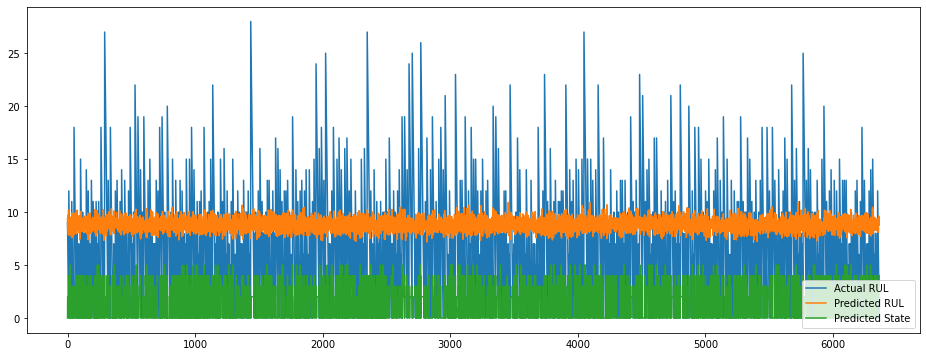

In [59]:
#plot graph for training set
plt.figure(figsize=(16, 6))
plt.plot(trainTime,trainRUL) #plot actual RUL
plt.plot(trainTime,trainPredictedRUL1) #plot predicted RUL
plt.plot(trainTime,trainPredictedStates) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

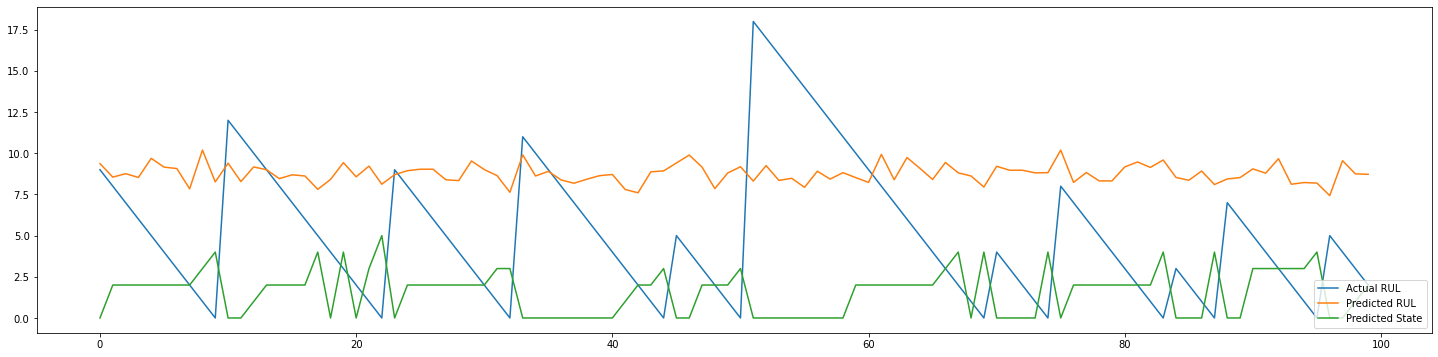

In [60]:
#plot graph for training set
plt.figure(figsize=(25, 6))
plt.plot(trainTime[:100],trainRUL[:100]) #plot actual RUL
plt.plot(trainTime[:100],trainPredictedRUL1[:100]) #plot predicted RUL
plt.plot(trainTime[:100],trainPredictedStates[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

In [61]:
#validation set predictions 
transitionMatrix = hmmModel1.transmat_
possibleStates = [0,1,2,3,4,5]
valPredictedRUL1 = rulPredictor(hmmModel1, val_readings_format, transitionMatrix, possibleStates, 100, 3)
valScore = math.sqrt(mean_squared_error(valRUL, valPredictedRUL1))
print("Root mean squared error of training set is %f" % (valScore))

At 0 predicted RUL is 9.080000
At 1 predicted RUL is 9.590000
At 2 predicted RUL is 9.640000
At 3 predicted RUL is 9.490000
At 4 predicted RUL is 8.000000
At 5 predicted RUL is 8.700000
At 6 predicted RUL is 9.820000
At 7 predicted RUL is 9.660000
At 8 predicted RUL is 8.970000
At 9 predicted RUL is 8.860000
At 10 predicted RUL is 7.780000
At 11 predicted RUL is 10.040000
At 12 predicted RUL is 8.630000
At 13 predicted RUL is 8.880000
At 14 predicted RUL is 9.440000
At 15 predicted RUL is 9.260000
At 16 predicted RUL is 8.650000
At 17 predicted RUL is 9.650000
At 18 predicted RUL is 8.620000
At 19 predicted RUL is 8.620000
At 20 predicted RUL is 8.540000
At 21 predicted RUL is 9.500000
At 22 predicted RUL is 8.940000
At 23 predicted RUL is 8.070000
At 24 predicted RUL is 10.260000
At 25 predicted RUL is 9.550000
At 26 predicted RUL is 8.530000
At 27 predicted RUL is 8.980000
At 28 predicted RUL is 8.240000
At 29 predicted RUL is 8.980000
At 30 predicted RUL is 9.050000
At 31 predicted 

At 253 predicted RUL is 9.130000
At 254 predicted RUL is 8.970000
At 255 predicted RUL is 8.010000
At 256 predicted RUL is 9.090000
At 257 predicted RUL is 8.220000
At 258 predicted RUL is 7.430000
At 259 predicted RUL is 9.070000
At 260 predicted RUL is 8.380000
At 261 predicted RUL is 9.500000
At 262 predicted RUL is 8.370000
At 263 predicted RUL is 8.110000
At 264 predicted RUL is 9.160000
At 265 predicted RUL is 9.280000
At 266 predicted RUL is 8.710000
At 267 predicted RUL is 8.490000
At 268 predicted RUL is 8.600000
At 269 predicted RUL is 8.190000
At 270 predicted RUL is 9.340000
At 271 predicted RUL is 8.180000
At 272 predicted RUL is 9.090000
At 273 predicted RUL is 7.720000
At 274 predicted RUL is 7.970000
At 275 predicted RUL is 7.860000
At 276 predicted RUL is 8.560000
At 277 predicted RUL is 9.090000
At 278 predicted RUL is 9.550000
At 279 predicted RUL is 8.490000
At 280 predicted RUL is 7.620000
At 281 predicted RUL is 9.900000
At 282 predicted RUL is 8.660000
At 283 pre

At 502 predicted RUL is 9.010000
At 503 predicted RUL is 9.200000
At 504 predicted RUL is 7.720000
At 505 predicted RUL is 9.140000
At 506 predicted RUL is 9.510000
At 507 predicted RUL is 9.990000
At 508 predicted RUL is 8.760000
At 509 predicted RUL is 8.680000
At 510 predicted RUL is 9.460000
At 511 predicted RUL is 9.290000
At 512 predicted RUL is 8.670000
At 513 predicted RUL is 8.930000
At 514 predicted RUL is 8.480000
At 515 predicted RUL is 8.490000
At 516 predicted RUL is 9.310000
At 517 predicted RUL is 8.840000
At 518 predicted RUL is 9.010000
At 519 predicted RUL is 8.290000
At 520 predicted RUL is 9.690000
At 521 predicted RUL is 8.480000
At 522 predicted RUL is 8.550000
At 523 predicted RUL is 9.050000
At 524 predicted RUL is 9.060000
At 525 predicted RUL is 9.420000
At 526 predicted RUL is 9.260000
At 527 predicted RUL is 9.990000
At 528 predicted RUL is 7.850000
At 529 predicted RUL is 8.800000
At 530 predicted RUL is 8.680000
At 531 predicted RUL is 8.630000
At 532 pre

At 752 predicted RUL is 8.890000
At 753 predicted RUL is 8.300000
At 754 predicted RUL is 8.310000
At 755 predicted RUL is 8.690000
At 756 predicted RUL is 8.440000
At 757 predicted RUL is 9.730000
At 758 predicted RUL is 8.570000
At 759 predicted RUL is 8.710000
At 760 predicted RUL is 8.410000
At 761 predicted RUL is 8.630000
At 762 predicted RUL is 8.180000
At 763 predicted RUL is 9.330000
At 764 predicted RUL is 8.230000
At 765 predicted RUL is 8.440000
At 766 predicted RUL is 8.930000
At 767 predicted RUL is 7.940000
At 768 predicted RUL is 9.500000
At 769 predicted RUL is 8.100000
At 770 predicted RUL is 9.130000
At 771 predicted RUL is 7.770000
At 772 predicted RUL is 9.440000
At 773 predicted RUL is 9.730000
At 774 predicted RUL is 9.060000
At 775 predicted RUL is 7.990000
At 776 predicted RUL is 8.020000
At 777 predicted RUL is 8.490000
At 778 predicted RUL is 8.940000
At 779 predicted RUL is 9.590000
At 780 predicted RUL is 8.390000
At 781 predicted RUL is 8.840000
At 782 pre

In [62]:
valR2Score = r2_score(valRUL, valPredictedRUL1)
print("R2 Score of validation set is %f" % (valR2Score))

R2 Score of validation set is -0.446452


In [63]:
valSscore = findSscore(valRUL, valPredictedRUL1)
print("S Score of validation set is %f" % (valSscore))

S Score of validation set is 1244.273284


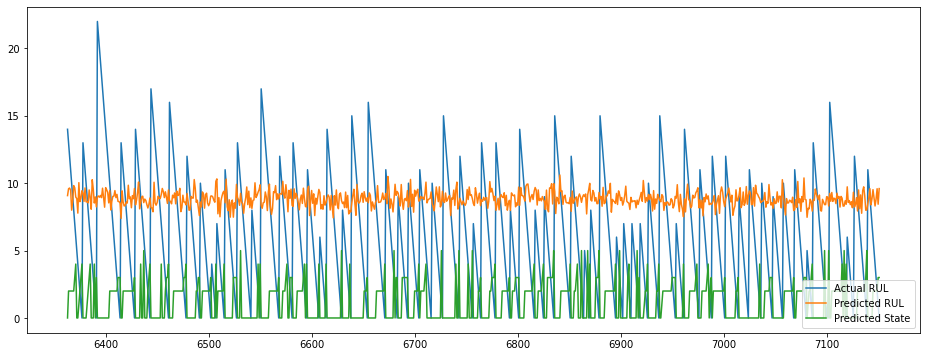

In [64]:
#plot graph for validation set
plt.figure(figsize=(16, 6))
plt.plot(valTime,valRUL) #plot actual RUL
plt.plot(valTime,valPredictedRUL1) #plot predicted RUL
plt.plot(valTime,valPredictedStates) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

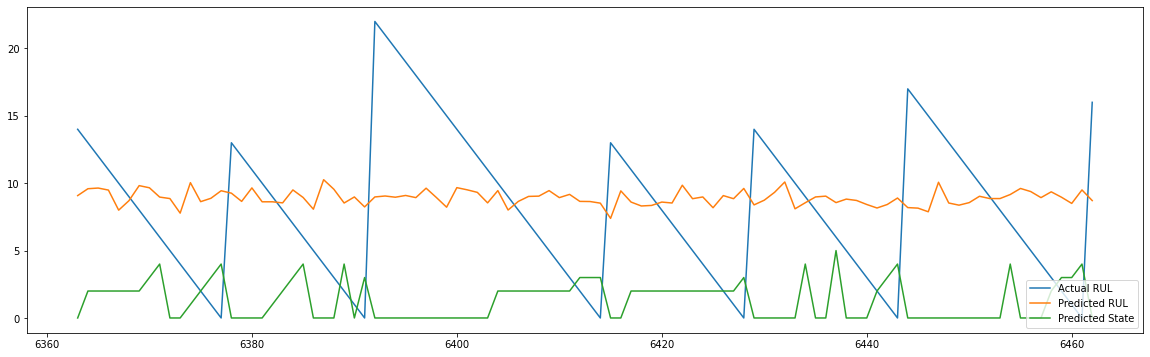

In [65]:
#plot graph for validation set
plt.figure(figsize=(20, 6))
plt.plot(valTime[:100],valRUL[:100]) #plot actual RUL
plt.plot(valTime[:100],valPredictedRUL1[:100]) #plot predicted RUL
plt.plot(valTime[:100],valPredictedStates[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

### Model 2 (Fix initial starting probability)

In [66]:
hmmModel2 = GMMHMM(n_components=6, n_mix=2, covariance_type='diag', algorithm='viterbi', random_state=42, n_iter=300, params='tmcw', init_params='mcw')

In [67]:
#fix parameters 
hmmModel2.startprob_ = startProb

In [68]:
hmmModel2.transmat_ = initial_transmat

In [69]:
hmmModel2.fit(X=train_readings_format, lengths=train_length)

GMMHMM(covars_prior=array([[[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]]]),
       covars_weight=array([[[0., 0., 0., 0.],
        [0., 0., 0....
       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]),
       n_components=6, n_iter=300, n_mix=2, params='tmcw', random_state=42,
       weights_pri

In [70]:
hmmModel2.startprob_

array([1., 0., 0., 0., 0., 0.])

In [71]:
hmmModel2.transmat_

array([[0.31030427, 0.1683649 , 0.08075628, 0.00522766, 0.42888507,
        0.00646183],
       [0.        , 0.71275784, 0.08466248, 0.13457938, 0.01490336,
        0.05309694],
       [0.        , 0.        , 0.08937056, 0.27107776, 0.59512629,
        0.04442539],
       [0.        , 0.        , 0.        , 0.76120819, 0.03106664,
        0.20772517],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [72]:
hmmModel2.weights_

array([[0.92832365, 0.07167635],
       [0.86970118, 0.13029882],
       [0.4268547 , 0.5731453 ],
       [0.55487719, 0.44512281],
       [0.12652502, 0.87347498],
       [0.46988502, 0.53011498]])

In [73]:
hmmModel2.means_

array([[[0.358511  , 0.63892088, 0.21503328, 0.25132338],
        [0.39986923, 0.55471667, 0.24568498, 0.41498404]],

       [[0.36729142, 0.63535532, 0.21793217, 0.23759851],
        [0.56800771, 0.64136558, 0.21900546, 0.24833829]],

       [[0.36623088, 0.63910721, 0.43343083, 0.24300368],
        [0.35922735, 0.63725356, 0.21443762, 0.54114436]],

       [[0.47101867, 0.63864517, 0.21599928, 0.23651626],
        [0.36077045, 0.37943224, 0.21846133, 0.24938208]],

       [[0.35831613, 0.41389297, 0.21130608, 0.2463829 ],
        [0.35877474, 0.63850027, 0.21475457, 0.25598647]],

       [[0.35863551, 0.63839653, 0.51114432, 0.2511437 ],
        [0.46575238, 0.54575159, 0.3905082 , 0.33328317]]])

In [74]:
hmmModel2.covars_

array([[[0.00104514, 0.00105678, 0.00057126, 0.00103825],
        [0.00883207, 0.01869105, 0.00624108, 0.02130289]],

       [[0.00103373, 0.00110953, 0.0005784 , 0.00071777],
        [0.00231534, 0.00085896, 0.00052545, 0.00083908]],

       [[0.00098016, 0.00069865, 0.00867534, 0.0011769 ],
        [0.00081504, 0.00084164, 0.00049685, 0.00318466]],

       [[0.01035764, 0.00106891, 0.00054432, 0.00083075],
        [0.00102504, 0.00144654, 0.00059351, 0.00073442]],

       [[0.0012034 , 0.00433668, 0.00054189, 0.00121935],
        [0.00106763, 0.00095872, 0.00049973, 0.00091876]],

       [[0.00127292, 0.0013993 , 0.00074185, 0.00066995],
        [0.01516171, 0.01484042, 0.02809688, 0.01759691]]])

In [75]:
hmmModel2.monitor_.converged

True

In [76]:
trainPredictedStates2 = hmmModel2.predict(train_readings_format, lengths=train_length)

In [77]:
def findPredictedStateByIndex(predictedValues, indexList):
    output = []
    for order in indexList:
        order = int(order)
        predictedState = predictedValues[order]
        output.append(predictedState)
    return output

In [78]:
#find states at end of episode (training set)
from collections import Counter
trainEndPredictedStates2 = findPredictedStateByIndex(trainPredictedStates2, trainEndIndexes)
Counter(trainEndPredictedStates2)

Counter({5: 85, 0: 40, 3: 172, 1: 91, 4: 58, 2: 88})

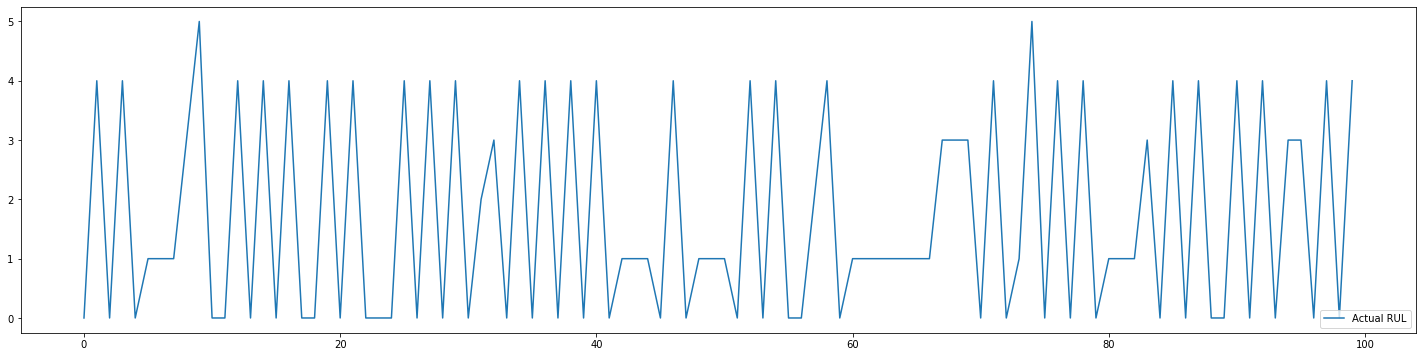

In [79]:
#plot graph for training set
plt.figure(figsize=(25, 6))
plt.plot(trainTime[:100],trainPredictedStates2[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

In [80]:
#Assume fail state is state 4 and 5
#training set predictions 
transitionMatrix2 = hmmModel2.transmat_
possibleStates = [0,1,2,3,4,5]
trainPredictedRUL2 = rulPredictor(hmmModel2, train_readings_format, transitionMatrix2, possibleStates, 100, 3)
trainScore2 = math.sqrt(mean_squared_error(trainRUL, trainPredictedRUL2))
print("Root mean squared error of training set is %f" % (trainScore2))

At 0 predicted RUL is 2.770000
At 1 predicted RUL is 2.790000
At 2 predicted RUL is 3.840000
At 3 predicted RUL is 3.120000
At 4 predicted RUL is 3.610000
At 5 predicted RUL is 3.740000
At 6 predicted RUL is 2.800000
At 7 predicted RUL is 3.140000
At 8 predicted RUL is 3.090000
At 9 predicted RUL is 3.520000
At 10 predicted RUL is 2.800000
At 11 predicted RUL is 3.670000
At 12 predicted RUL is 3.650000
At 13 predicted RUL is 3.250000
At 14 predicted RUL is 3.160000
At 15 predicted RUL is 3.610000
At 16 predicted RUL is 3.390000
At 17 predicted RUL is 3.270000
At 18 predicted RUL is 3.050000
At 19 predicted RUL is 2.920000
At 20 predicted RUL is 3.170000
At 21 predicted RUL is 3.040000
At 22 predicted RUL is 3.490000
At 23 predicted RUL is 2.870000
At 24 predicted RUL is 3.390000
At 25 predicted RUL is 2.560000
At 26 predicted RUL is 2.870000
At 27 predicted RUL is 2.740000
At 28 predicted RUL is 3.250000
At 29 predicted RUL is 3.010000
At 30 predicted RUL is 3.390000
At 31 predicted RU

At 252 predicted RUL is 3.280000
At 253 predicted RUL is 4.400000
At 254 predicted RUL is 3.310000
At 255 predicted RUL is 3.180000
At 256 predicted RUL is 3.300000
At 257 predicted RUL is 3.710000
At 258 predicted RUL is 2.980000
At 259 predicted RUL is 2.730000
At 260 predicted RUL is 3.370000
At 261 predicted RUL is 2.940000
At 262 predicted RUL is 3.490000
At 263 predicted RUL is 3.920000
At 264 predicted RUL is 3.300000
At 265 predicted RUL is 3.380000
At 266 predicted RUL is 2.770000
At 267 predicted RUL is 3.320000
At 268 predicted RUL is 3.380000
At 269 predicted RUL is 3.760000
At 270 predicted RUL is 3.430000
At 271 predicted RUL is 3.440000
At 272 predicted RUL is 3.200000
At 273 predicted RUL is 2.800000
At 274 predicted RUL is 3.690000
At 275 predicted RUL is 2.960000
At 276 predicted RUL is 2.970000
At 277 predicted RUL is 3.450000
At 278 predicted RUL is 2.990000
At 279 predicted RUL is 3.260000
At 280 predicted RUL is 2.710000
At 281 predicted RUL is 3.530000
At 282 pre

At 504 predicted RUL is 2.930000
At 505 predicted RUL is 3.060000
At 506 predicted RUL is 3.230000
At 507 predicted RUL is 3.370000
At 508 predicted RUL is 3.500000
At 509 predicted RUL is 3.660000
At 510 predicted RUL is 3.590000
At 511 predicted RUL is 3.190000
At 512 predicted RUL is 2.180000
At 513 predicted RUL is 2.880000
At 514 predicted RUL is 3.420000
At 515 predicted RUL is 3.180000
At 516 predicted RUL is 2.950000
At 517 predicted RUL is 3.830000
At 518 predicted RUL is 3.800000
At 519 predicted RUL is 2.960000
At 520 predicted RUL is 2.980000
At 521 predicted RUL is 3.380000
At 522 predicted RUL is 3.500000
At 523 predicted RUL is 3.510000
At 524 predicted RUL is 3.390000
At 525 predicted RUL is 3.430000
At 526 predicted RUL is 2.950000
At 527 predicted RUL is 3.140000
At 528 predicted RUL is 2.550000
At 529 predicted RUL is 2.840000
At 530 predicted RUL is 2.980000
At 531 predicted RUL is 3.310000
At 532 predicted RUL is 3.200000
At 533 predicted RUL is 3.430000
At 534 pre

At 764 predicted RUL is 3.470000
At 765 predicted RUL is 3.390000
At 766 predicted RUL is 3.010000
At 767 predicted RUL is 3.050000
At 768 predicted RUL is 3.230000
At 769 predicted RUL is 3.230000
At 770 predicted RUL is 2.980000
At 771 predicted RUL is 3.120000
At 772 predicted RUL is 3.210000
At 773 predicted RUL is 3.280000
At 774 predicted RUL is 3.340000
At 775 predicted RUL is 3.350000
At 776 predicted RUL is 3.790000
At 777 predicted RUL is 3.700000
At 778 predicted RUL is 3.600000
At 779 predicted RUL is 3.100000
At 780 predicted RUL is 2.920000
At 781 predicted RUL is 2.900000
At 782 predicted RUL is 3.680000
At 783 predicted RUL is 3.040000
At 784 predicted RUL is 4.150000
At 785 predicted RUL is 3.160000
At 786 predicted RUL is 3.130000
At 787 predicted RUL is 3.410000
At 788 predicted RUL is 2.890000
At 789 predicted RUL is 3.690000
At 790 predicted RUL is 3.410000
At 791 predicted RUL is 3.030000
At 792 predicted RUL is 3.900000
At 793 predicted RUL is 3.250000
At 794 pre

At 1019 predicted RUL is 3.230000
At 1020 predicted RUL is 3.330000
At 1021 predicted RUL is 3.330000
At 1022 predicted RUL is 3.270000
At 1023 predicted RUL is 3.190000
At 1024 predicted RUL is 3.530000
At 1025 predicted RUL is 3.110000
At 1026 predicted RUL is 3.480000
At 1027 predicted RUL is 3.240000
At 1028 predicted RUL is 3.320000
At 1029 predicted RUL is 3.310000
At 1030 predicted RUL is 3.750000
At 1031 predicted RUL is 3.780000
At 1032 predicted RUL is 3.710000
At 1033 predicted RUL is 2.530000
At 1034 predicted RUL is 3.210000
At 1035 predicted RUL is 2.910000
At 1036 predicted RUL is 2.700000
At 1037 predicted RUL is 3.050000
At 1038 predicted RUL is 3.150000
At 1039 predicted RUL is 3.280000
At 1040 predicted RUL is 2.940000
At 1041 predicted RUL is 3.230000
At 1042 predicted RUL is 3.030000
At 1043 predicted RUL is 3.620000
At 1044 predicted RUL is 3.470000
At 1045 predicted RUL is 2.980000
At 1046 predicted RUL is 2.850000
At 1047 predicted RUL is 3.560000
At 1048 predic

At 1262 predicted RUL is 2.830000
At 1263 predicted RUL is 3.140000
At 1264 predicted RUL is 3.130000
At 1265 predicted RUL is 2.740000
At 1266 predicted RUL is 3.260000
At 1267 predicted RUL is 3.600000
At 1268 predicted RUL is 3.610000
At 1269 predicted RUL is 3.930000
At 1270 predicted RUL is 3.030000
At 1271 predicted RUL is 3.260000
At 1272 predicted RUL is 2.860000
At 1273 predicted RUL is 3.000000
At 1274 predicted RUL is 3.090000
At 1275 predicted RUL is 2.720000
At 1276 predicted RUL is 2.990000
At 1277 predicted RUL is 3.270000
At 1278 predicted RUL is 3.110000
At 1279 predicted RUL is 3.280000
At 1280 predicted RUL is 3.290000
At 1281 predicted RUL is 3.920000
At 1282 predicted RUL is 3.140000
At 1283 predicted RUL is 3.790000
At 1284 predicted RUL is 2.850000
At 1285 predicted RUL is 3.250000
At 1286 predicted RUL is 3.070000
At 1287 predicted RUL is 3.030000
At 1288 predicted RUL is 3.490000
At 1289 predicted RUL is 3.100000
At 1290 predicted RUL is 2.770000
At 1291 predic

At 1504 predicted RUL is 3.120000
At 1505 predicted RUL is 3.430000
At 1506 predicted RUL is 3.330000
At 1507 predicted RUL is 3.460000
At 1508 predicted RUL is 3.300000
At 1509 predicted RUL is 3.070000
At 1510 predicted RUL is 3.370000
At 1511 predicted RUL is 3.700000
At 1512 predicted RUL is 3.460000
At 1513 predicted RUL is 3.580000
At 1514 predicted RUL is 2.880000
At 1515 predicted RUL is 3.240000
At 1516 predicted RUL is 3.250000
At 1517 predicted RUL is 3.050000
At 1518 predicted RUL is 2.970000
At 1519 predicted RUL is 3.260000
At 1520 predicted RUL is 3.110000
At 1521 predicted RUL is 3.490000
At 1522 predicted RUL is 2.970000
At 1523 predicted RUL is 3.440000
At 1524 predicted RUL is 3.600000
At 1525 predicted RUL is 3.620000
At 1526 predicted RUL is 2.770000
At 1527 predicted RUL is 3.700000
At 1528 predicted RUL is 2.750000
At 1529 predicted RUL is 3.010000
At 1530 predicted RUL is 3.150000
At 1531 predicted RUL is 3.400000
At 1532 predicted RUL is 3.270000
At 1533 predic

At 1747 predicted RUL is 3.110000
At 1748 predicted RUL is 3.500000
At 1749 predicted RUL is 3.030000
At 1750 predicted RUL is 2.650000
At 1751 predicted RUL is 3.520000
At 1752 predicted RUL is 3.310000
At 1753 predicted RUL is 2.550000
At 1754 predicted RUL is 3.270000
At 1755 predicted RUL is 3.430000
At 1756 predicted RUL is 3.660000
At 1757 predicted RUL is 3.020000
At 1758 predicted RUL is 2.530000
At 1759 predicted RUL is 3.400000
At 1760 predicted RUL is 2.590000
At 1761 predicted RUL is 2.990000
At 1762 predicted RUL is 2.830000
At 1763 predicted RUL is 3.950000
At 1764 predicted RUL is 3.080000
At 1765 predicted RUL is 3.180000
At 1766 predicted RUL is 3.760000
At 1767 predicted RUL is 3.330000
At 1768 predicted RUL is 3.370000
At 1769 predicted RUL is 3.350000
At 1770 predicted RUL is 3.530000
At 1771 predicted RUL is 3.020000
At 1772 predicted RUL is 3.590000
At 1773 predicted RUL is 3.380000
At 1774 predicted RUL is 3.080000
At 1775 predicted RUL is 3.090000
At 1776 predic

At 1993 predicted RUL is 3.670000
At 1994 predicted RUL is 2.740000
At 1995 predicted RUL is 3.670000
At 1996 predicted RUL is 3.270000
At 1997 predicted RUL is 2.980000
At 1998 predicted RUL is 2.820000
At 1999 predicted RUL is 3.650000
At 2000 predicted RUL is 3.320000
At 2001 predicted RUL is 3.420000
At 2002 predicted RUL is 3.460000
At 2003 predicted RUL is 3.260000
At 2004 predicted RUL is 4.360000
At 2005 predicted RUL is 2.960000
At 2006 predicted RUL is 3.270000
At 2007 predicted RUL is 3.010000
At 2008 predicted RUL is 3.700000
At 2009 predicted RUL is 2.880000
At 2010 predicted RUL is 2.950000
At 2011 predicted RUL is 3.240000
At 2012 predicted RUL is 3.770000
At 2013 predicted RUL is 2.930000
At 2014 predicted RUL is 2.680000
At 2015 predicted RUL is 3.280000
At 2016 predicted RUL is 2.980000
At 2017 predicted RUL is 2.680000
At 2018 predicted RUL is 3.330000
At 2019 predicted RUL is 3.280000
At 2020 predicted RUL is 3.350000
At 2021 predicted RUL is 2.810000
At 2022 predic

At 2239 predicted RUL is 3.650000
At 2240 predicted RUL is 3.430000
At 2241 predicted RUL is 3.010000
At 2242 predicted RUL is 3.630000
At 2243 predicted RUL is 2.750000
At 2244 predicted RUL is 3.240000
At 2245 predicted RUL is 2.740000
At 2246 predicted RUL is 2.940000
At 2247 predicted RUL is 3.710000
At 2248 predicted RUL is 2.880000
At 2249 predicted RUL is 3.200000
At 2250 predicted RUL is 2.860000
At 2251 predicted RUL is 3.570000
At 2252 predicted RUL is 3.350000
At 2253 predicted RUL is 3.360000
At 2254 predicted RUL is 2.660000
At 2255 predicted RUL is 2.790000
At 2256 predicted RUL is 3.500000
At 2257 predicted RUL is 3.380000
At 2258 predicted RUL is 3.030000
At 2259 predicted RUL is 3.230000
At 2260 predicted RUL is 3.010000
At 2261 predicted RUL is 2.890000
At 2262 predicted RUL is 3.390000
At 2263 predicted RUL is 3.500000
At 2264 predicted RUL is 3.190000
At 2265 predicted RUL is 3.070000
At 2266 predicted RUL is 3.940000
At 2267 predicted RUL is 3.290000
At 2268 predic

At 2480 predicted RUL is 4.060000
At 2481 predicted RUL is 3.540000
At 2482 predicted RUL is 3.010000
At 2483 predicted RUL is 3.440000
At 2484 predicted RUL is 3.130000
At 2485 predicted RUL is 3.990000
At 2486 predicted RUL is 3.390000
At 2487 predicted RUL is 3.310000
At 2488 predicted RUL is 2.940000
At 2489 predicted RUL is 2.840000
At 2490 predicted RUL is 3.130000
At 2491 predicted RUL is 3.640000
At 2492 predicted RUL is 3.320000
At 2493 predicted RUL is 3.550000
At 2494 predicted RUL is 3.660000
At 2495 predicted RUL is 3.140000
At 2496 predicted RUL is 3.170000
At 2497 predicted RUL is 3.380000
At 2498 predicted RUL is 3.120000
At 2499 predicted RUL is 3.550000
At 2500 predicted RUL is 3.980000
At 2501 predicted RUL is 3.260000
At 2502 predicted RUL is 2.470000
At 2503 predicted RUL is 3.720000
At 2504 predicted RUL is 3.390000
At 2505 predicted RUL is 3.520000
At 2506 predicted RUL is 3.950000
At 2507 predicted RUL is 3.490000
At 2508 predicted RUL is 3.420000
At 2509 predic

At 2723 predicted RUL is 2.850000
At 2724 predicted RUL is 2.810000
At 2725 predicted RUL is 2.880000
At 2726 predicted RUL is 2.660000
At 2727 predicted RUL is 3.660000
At 2728 predicted RUL is 3.140000
At 2729 predicted RUL is 3.500000
At 2730 predicted RUL is 3.460000
At 2731 predicted RUL is 2.950000
At 2732 predicted RUL is 2.770000
At 2733 predicted RUL is 3.350000
At 2734 predicted RUL is 3.380000
At 2735 predicted RUL is 3.280000
At 2736 predicted RUL is 3.820000
At 2737 predicted RUL is 2.980000
At 2738 predicted RUL is 3.280000
At 2739 predicted RUL is 3.910000
At 2740 predicted RUL is 3.610000
At 2741 predicted RUL is 2.750000
At 2742 predicted RUL is 3.130000
At 2743 predicted RUL is 3.660000
At 2744 predicted RUL is 3.260000
At 2745 predicted RUL is 2.740000
At 2746 predicted RUL is 3.190000
At 2747 predicted RUL is 3.630000
At 2748 predicted RUL is 3.220000
At 2749 predicted RUL is 3.510000
At 2750 predicted RUL is 3.440000
At 2751 predicted RUL is 3.450000
At 2752 predic

At 2966 predicted RUL is 3.010000
At 2967 predicted RUL is 3.230000
At 2968 predicted RUL is 3.580000
At 2969 predicted RUL is 3.150000
At 2970 predicted RUL is 3.370000
At 2971 predicted RUL is 3.480000
At 2972 predicted RUL is 3.500000
At 2973 predicted RUL is 2.900000
At 2974 predicted RUL is 2.670000
At 2975 predicted RUL is 3.200000
At 2976 predicted RUL is 3.310000
At 2977 predicted RUL is 3.200000
At 2978 predicted RUL is 3.460000
At 2979 predicted RUL is 3.120000
At 2980 predicted RUL is 3.340000
At 2981 predicted RUL is 3.180000
At 2982 predicted RUL is 3.220000
At 2983 predicted RUL is 3.770000
At 2984 predicted RUL is 3.270000
At 2985 predicted RUL is 3.040000
At 2986 predicted RUL is 3.040000
At 2987 predicted RUL is 3.410000
At 2988 predicted RUL is 3.110000
At 2989 predicted RUL is 3.680000
At 2990 predicted RUL is 2.430000
At 2991 predicted RUL is 3.750000
At 2992 predicted RUL is 3.430000
At 2993 predicted RUL is 2.990000
At 2994 predicted RUL is 3.080000
At 2995 predic

At 3210 predicted RUL is 3.230000
At 3211 predicted RUL is 3.060000
At 3212 predicted RUL is 3.380000
At 3213 predicted RUL is 2.430000
At 3214 predicted RUL is 3.420000
At 3215 predicted RUL is 3.650000
At 3216 predicted RUL is 3.560000
At 3217 predicted RUL is 3.020000
At 3218 predicted RUL is 3.130000
At 3219 predicted RUL is 3.130000
At 3220 predicted RUL is 3.260000
At 3221 predicted RUL is 2.970000
At 3222 predicted RUL is 3.400000
At 3223 predicted RUL is 3.320000
At 3224 predicted RUL is 3.220000
At 3225 predicted RUL is 3.170000
At 3226 predicted RUL is 3.010000
At 3227 predicted RUL is 2.760000
At 3228 predicted RUL is 2.900000
At 3229 predicted RUL is 2.680000
At 3230 predicted RUL is 2.950000
At 3231 predicted RUL is 2.970000
At 3232 predicted RUL is 3.420000
At 3233 predicted RUL is 2.990000
At 3234 predicted RUL is 3.520000
At 3235 predicted RUL is 3.040000
At 3236 predicted RUL is 3.440000
At 3237 predicted RUL is 3.190000
At 3238 predicted RUL is 2.810000
At 3239 predic

At 3456 predicted RUL is 2.960000
At 3457 predicted RUL is 3.790000
At 3458 predicted RUL is 2.760000
At 3459 predicted RUL is 3.060000
At 3460 predicted RUL is 3.230000
At 3461 predicted RUL is 3.460000
At 3462 predicted RUL is 3.370000
At 3463 predicted RUL is 3.100000
At 3464 predicted RUL is 2.750000
At 3465 predicted RUL is 3.530000
At 3466 predicted RUL is 3.160000
At 3467 predicted RUL is 3.420000
At 3468 predicted RUL is 3.540000
At 3469 predicted RUL is 3.390000
At 3470 predicted RUL is 3.230000
At 3471 predicted RUL is 3.690000
At 3472 predicted RUL is 3.220000
At 3473 predicted RUL is 3.040000
At 3474 predicted RUL is 2.870000
At 3475 predicted RUL is 3.410000
At 3476 predicted RUL is 3.160000
At 3477 predicted RUL is 3.460000
At 3478 predicted RUL is 3.580000
At 3479 predicted RUL is 2.930000
At 3480 predicted RUL is 2.980000
At 3481 predicted RUL is 3.630000
At 3482 predicted RUL is 3.260000
At 3483 predicted RUL is 3.280000
At 3484 predicted RUL is 3.090000
At 3485 predic

At 3703 predicted RUL is 2.910000
At 3704 predicted RUL is 3.110000
At 3705 predicted RUL is 2.970000
At 3706 predicted RUL is 3.220000
At 3707 predicted RUL is 3.260000
At 3708 predicted RUL is 3.520000
At 3709 predicted RUL is 3.130000
At 3710 predicted RUL is 3.370000
At 3711 predicted RUL is 3.290000
At 3712 predicted RUL is 3.610000
At 3713 predicted RUL is 3.210000
At 3714 predicted RUL is 3.640000
At 3715 predicted RUL is 3.450000
At 3716 predicted RUL is 2.470000
At 3717 predicted RUL is 3.710000
At 3718 predicted RUL is 3.550000
At 3719 predicted RUL is 3.580000
At 3720 predicted RUL is 3.540000
At 3721 predicted RUL is 3.250000
At 3722 predicted RUL is 2.990000
At 3723 predicted RUL is 3.240000
At 3724 predicted RUL is 3.240000
At 3725 predicted RUL is 3.340000
At 3726 predicted RUL is 3.050000
At 3727 predicted RUL is 2.910000
At 3728 predicted RUL is 3.400000
At 3729 predicted RUL is 3.180000
At 3730 predicted RUL is 3.460000
At 3731 predicted RUL is 4.350000
At 3732 predic

At 3947 predicted RUL is 3.250000
At 3948 predicted RUL is 2.640000
At 3949 predicted RUL is 3.530000
At 3950 predicted RUL is 3.820000
At 3951 predicted RUL is 2.640000
At 3952 predicted RUL is 3.480000
At 3953 predicted RUL is 3.160000
At 3954 predicted RUL is 3.320000
At 3955 predicted RUL is 2.920000
At 3956 predicted RUL is 2.900000
At 3957 predicted RUL is 3.300000
At 3958 predicted RUL is 3.570000
At 3959 predicted RUL is 2.980000
At 3960 predicted RUL is 2.530000
At 3961 predicted RUL is 3.230000
At 3962 predicted RUL is 3.170000
At 3963 predicted RUL is 3.220000
At 3964 predicted RUL is 3.450000
At 3965 predicted RUL is 2.930000
At 3966 predicted RUL is 3.600000
At 3967 predicted RUL is 3.490000
At 3968 predicted RUL is 3.190000
At 3969 predicted RUL is 3.210000
At 3970 predicted RUL is 3.200000
At 3971 predicted RUL is 3.680000
At 3972 predicted RUL is 3.510000
At 3973 predicted RUL is 2.990000
At 3974 predicted RUL is 3.710000
At 3975 predicted RUL is 3.560000
At 3976 predic

At 4195 predicted RUL is 3.370000
At 4196 predicted RUL is 2.890000
At 4197 predicted RUL is 2.770000
At 4198 predicted RUL is 2.750000
At 4199 predicted RUL is 3.780000
At 4200 predicted RUL is 3.230000
At 4201 predicted RUL is 3.350000
At 4202 predicted RUL is 3.480000
At 4203 predicted RUL is 3.360000
At 4204 predicted RUL is 3.530000
At 4205 predicted RUL is 3.480000
At 4206 predicted RUL is 4.000000
At 4207 predicted RUL is 3.420000
At 4208 predicted RUL is 3.030000
At 4209 predicted RUL is 3.780000
At 4210 predicted RUL is 3.600000
At 4211 predicted RUL is 3.240000
At 4212 predicted RUL is 3.800000
At 4213 predicted RUL is 4.000000
At 4214 predicted RUL is 3.790000
At 4215 predicted RUL is 3.550000
At 4216 predicted RUL is 2.970000
At 4217 predicted RUL is 3.590000
At 4218 predicted RUL is 3.220000
At 4219 predicted RUL is 2.910000
At 4220 predicted RUL is 3.720000
At 4221 predicted RUL is 2.890000
At 4222 predicted RUL is 3.150000
At 4223 predicted RUL is 3.060000
At 4224 predic

At 4436 predicted RUL is 2.950000
At 4437 predicted RUL is 3.860000
At 4438 predicted RUL is 2.730000
At 4439 predicted RUL is 2.610000
At 4440 predicted RUL is 2.750000
At 4441 predicted RUL is 3.340000
At 4442 predicted RUL is 3.110000
At 4443 predicted RUL is 2.580000
At 4444 predicted RUL is 3.150000
At 4445 predicted RUL is 3.020000
At 4446 predicted RUL is 2.420000
At 4447 predicted RUL is 3.400000
At 4448 predicted RUL is 3.590000
At 4449 predicted RUL is 3.360000
At 4450 predicted RUL is 3.140000
At 4451 predicted RUL is 3.180000
At 4452 predicted RUL is 3.060000
At 4453 predicted RUL is 3.390000
At 4454 predicted RUL is 2.540000
At 4455 predicted RUL is 3.540000
At 4456 predicted RUL is 3.510000
At 4457 predicted RUL is 2.880000
At 4458 predicted RUL is 3.230000
At 4459 predicted RUL is 3.500000
At 4460 predicted RUL is 3.160000
At 4461 predicted RUL is 3.130000
At 4462 predicted RUL is 3.020000
At 4463 predicted RUL is 3.140000
At 4464 predicted RUL is 3.410000
At 4465 predic

At 4684 predicted RUL is 3.070000
At 4685 predicted RUL is 3.110000
At 4686 predicted RUL is 3.630000
At 4687 predicted RUL is 2.960000
At 4688 predicted RUL is 3.190000
At 4689 predicted RUL is 3.370000
At 4690 predicted RUL is 3.250000
At 4691 predicted RUL is 3.130000
At 4692 predicted RUL is 3.140000
At 4693 predicted RUL is 3.470000
At 4694 predicted RUL is 3.280000
At 4695 predicted RUL is 4.120000
At 4696 predicted RUL is 3.020000
At 4697 predicted RUL is 3.730000
At 4698 predicted RUL is 3.110000
At 4699 predicted RUL is 3.130000
At 4700 predicted RUL is 2.390000
At 4701 predicted RUL is 3.100000
At 4702 predicted RUL is 3.340000
At 4703 predicted RUL is 3.420000
At 4704 predicted RUL is 2.820000
At 4705 predicted RUL is 3.410000
At 4706 predicted RUL is 2.860000
At 4707 predicted RUL is 3.300000
At 4708 predicted RUL is 3.130000
At 4709 predicted RUL is 3.230000
At 4710 predicted RUL is 2.850000
At 4711 predicted RUL is 3.960000
At 4712 predicted RUL is 3.690000
At 4713 predic

At 4934 predicted RUL is 3.220000
At 4935 predicted RUL is 3.320000
At 4936 predicted RUL is 3.360000
At 4937 predicted RUL is 3.060000
At 4938 predicted RUL is 2.820000
At 4939 predicted RUL is 3.810000
At 4940 predicted RUL is 3.600000
At 4941 predicted RUL is 3.630000
At 4942 predicted RUL is 3.510000
At 4943 predicted RUL is 3.210000
At 4944 predicted RUL is 2.650000
At 4945 predicted RUL is 3.650000
At 4946 predicted RUL is 3.670000
At 4947 predicted RUL is 2.980000
At 4948 predicted RUL is 4.170000
At 4949 predicted RUL is 2.680000
At 4950 predicted RUL is 3.390000
At 4951 predicted RUL is 3.110000
At 4952 predicted RUL is 3.140000
At 4953 predicted RUL is 3.670000
At 4954 predicted RUL is 2.990000
At 4955 predicted RUL is 3.640000
At 4956 predicted RUL is 3.820000
At 4957 predicted RUL is 3.930000
At 4958 predicted RUL is 2.920000
At 4959 predicted RUL is 3.620000
At 4960 predicted RUL is 2.860000
At 4961 predicted RUL is 3.120000
At 4962 predicted RUL is 3.500000
At 4963 predic

At 5176 predicted RUL is 2.680000
At 5177 predicted RUL is 3.520000
At 5178 predicted RUL is 3.230000
At 5179 predicted RUL is 3.220000
At 5180 predicted RUL is 3.200000
At 5181 predicted RUL is 3.340000
At 5182 predicted RUL is 2.650000
At 5183 predicted RUL is 3.360000
At 5184 predicted RUL is 3.320000
At 5185 predicted RUL is 2.710000
At 5186 predicted RUL is 3.230000
At 5187 predicted RUL is 2.700000
At 5188 predicted RUL is 2.890000
At 5189 predicted RUL is 3.210000
At 5190 predicted RUL is 3.240000
At 5191 predicted RUL is 3.880000
At 5192 predicted RUL is 3.270000
At 5193 predicted RUL is 3.710000
At 5194 predicted RUL is 3.030000
At 5195 predicted RUL is 3.660000
At 5196 predicted RUL is 3.270000
At 5197 predicted RUL is 3.210000
At 5198 predicted RUL is 3.520000
At 5199 predicted RUL is 3.370000
At 5200 predicted RUL is 3.730000
At 5201 predicted RUL is 2.710000
At 5202 predicted RUL is 4.010000
At 5203 predicted RUL is 2.520000
At 5204 predicted RUL is 3.660000
At 5205 predic

At 5424 predicted RUL is 3.030000
At 5425 predicted RUL is 2.910000
At 5426 predicted RUL is 3.030000
At 5427 predicted RUL is 3.280000
At 5428 predicted RUL is 2.700000
At 5429 predicted RUL is 2.760000
At 5430 predicted RUL is 3.110000
At 5431 predicted RUL is 2.920000
At 5432 predicted RUL is 3.650000
At 5433 predicted RUL is 3.050000
At 5434 predicted RUL is 2.770000
At 5435 predicted RUL is 3.270000
At 5436 predicted RUL is 3.350000
At 5437 predicted RUL is 3.720000
At 5438 predicted RUL is 3.310000
At 5439 predicted RUL is 2.940000
At 5440 predicted RUL is 3.500000
At 5441 predicted RUL is 3.060000
At 5442 predicted RUL is 3.760000
At 5443 predicted RUL is 3.020000
At 5444 predicted RUL is 2.740000
At 5445 predicted RUL is 3.170000
At 5446 predicted RUL is 3.280000
At 5447 predicted RUL is 3.510000
At 5448 predicted RUL is 3.430000
At 5449 predicted RUL is 3.070000
At 5450 predicted RUL is 3.650000
At 5451 predicted RUL is 3.240000
At 5452 predicted RUL is 3.060000
At 5453 predic

At 5666 predicted RUL is 2.950000
At 5667 predicted RUL is 3.140000
At 5668 predicted RUL is 3.750000
At 5669 predicted RUL is 2.590000
At 5670 predicted RUL is 3.280000
At 5671 predicted RUL is 3.410000
At 5672 predicted RUL is 3.390000
At 5673 predicted RUL is 3.370000
At 5674 predicted RUL is 3.340000
At 5675 predicted RUL is 3.560000
At 5676 predicted RUL is 3.420000
At 5677 predicted RUL is 3.450000
At 5678 predicted RUL is 2.970000
At 5679 predicted RUL is 3.190000
At 5680 predicted RUL is 3.260000
At 5681 predicted RUL is 2.840000
At 5682 predicted RUL is 2.800000
At 5683 predicted RUL is 3.300000
At 5684 predicted RUL is 3.560000
At 5685 predicted RUL is 2.630000
At 5686 predicted RUL is 3.420000
At 5687 predicted RUL is 2.970000
At 5688 predicted RUL is 3.990000
At 5689 predicted RUL is 3.380000
At 5690 predicted RUL is 3.080000
At 5691 predicted RUL is 3.030000
At 5692 predicted RUL is 3.420000
At 5693 predicted RUL is 3.890000
At 5694 predicted RUL is 3.540000
At 5695 predic

At 6147 predicted RUL is 3.940000
At 6148 predicted RUL is 2.970000
At 6149 predicted RUL is 2.870000
At 6150 predicted RUL is 2.690000
At 6151 predicted RUL is 3.090000
At 6152 predicted RUL is 3.140000
At 6153 predicted RUL is 3.610000
At 6154 predicted RUL is 2.330000
At 6155 predicted RUL is 2.770000
At 6156 predicted RUL is 2.790000
At 6157 predicted RUL is 2.960000
At 6158 predicted RUL is 3.340000
At 6159 predicted RUL is 3.530000
At 6160 predicted RUL is 4.360000
At 6161 predicted RUL is 3.120000
At 6162 predicted RUL is 3.310000
At 6163 predicted RUL is 3.780000
At 6164 predicted RUL is 3.600000
At 6165 predicted RUL is 3.580000
At 6166 predicted RUL is 2.770000
At 6167 predicted RUL is 3.750000
At 6168 predicted RUL is 2.370000
At 6169 predicted RUL is 3.360000
At 6170 predicted RUL is 3.180000
At 6171 predicted RUL is 3.150000
At 6172 predicted RUL is 2.730000
At 6173 predicted RUL is 3.010000
At 6174 predicted RUL is 2.980000
At 6175 predicted RUL is 3.080000
At 6176 predic

In [81]:
trainR2Score2 = r2_score(trainRUL, trainPredictedRUL2)
print("R2 Score of training set is %f" % (trainR2Score2))

R2 Score of training set is -0.414170


In [114]:
trainSscore2 = findSscore(trainRUL, trainPredictedRUL2)
print("S Score of training set is %f" % (trainSscore2))

S Score of training set is 9534.114642


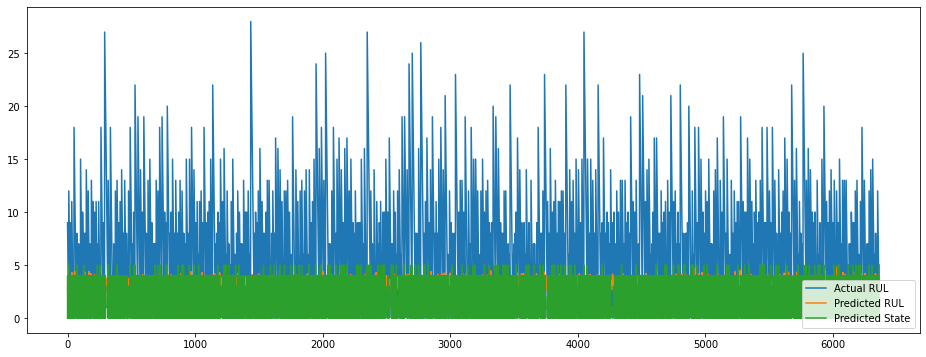

In [83]:
#plot graph for training set
plt.figure(figsize=(16, 6))
plt.plot(trainTime,trainRUL) #plot actual RUL
plt.plot(trainTime,trainPredictedRUL2) #plot predicted RUL
plt.plot(trainTime,trainPredictedStates2) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

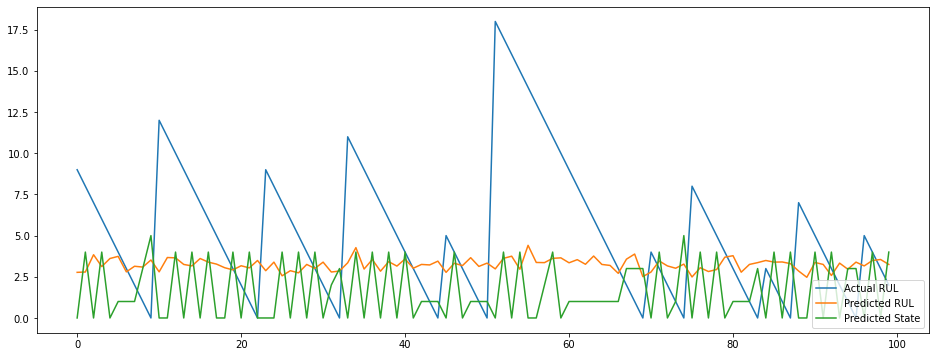

In [84]:
#plot graph for training set
plt.figure(figsize=(16, 6))
plt.plot(trainTime[:100],trainRUL[:100]) #plot actual RUL
plt.plot(trainTime[:100],trainPredictedRUL2[:100]) #plot predicted RUL
plt.plot(trainTime[:100],trainPredictedStates2[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

In [85]:
valPredictedStates2 = hmmModel2.predict(val_readings_format, lengths=val_length)

In [86]:
#validation set predictions 
transitionMatrix2 = hmmModel2.transmat_
valPredictedRUL2 = rulPredictor(hmmModel2, val_readings_format, transitionMatrix2, possibleStates, 100, 2)
valScore2 = math.sqrt(mean_squared_error(valRUL, valPredictedRUL2))
print("Root mean squared error of validation set is %f" % (valScore2))

At 0 predicted RUL is 2.640000
At 1 predicted RUL is 2.070000
At 2 predicted RUL is 2.650000
At 3 predicted RUL is 1.870000
At 4 predicted RUL is 2.460000
At 5 predicted RUL is 2.670000
At 6 predicted RUL is 2.700000
At 7 predicted RUL is 2.530000
At 8 predicted RUL is 2.700000
At 9 predicted RUL is 2.070000
At 10 predicted RUL is 2.460000
At 11 predicted RUL is 2.380000
At 12 predicted RUL is 2.440000
At 13 predicted RUL is 2.630000
At 14 predicted RUL is 2.330000
At 15 predicted RUL is 2.810000
At 16 predicted RUL is 2.420000
At 17 predicted RUL is 2.650000
At 18 predicted RUL is 2.830000
At 19 predicted RUL is 2.930000
At 20 predicted RUL is 2.050000
At 21 predicted RUL is 2.470000
At 22 predicted RUL is 2.560000
At 23 predicted RUL is 2.100000
At 24 predicted RUL is 2.620000
At 25 predicted RUL is 2.680000
At 26 predicted RUL is 2.610000
At 27 predicted RUL is 2.880000
At 28 predicted RUL is 2.340000
At 29 predicted RUL is 2.890000
At 30 predicted RUL is 2.580000
At 31 predicted RU

At 257 predicted RUL is 2.990000
At 258 predicted RUL is 2.370000
At 259 predicted RUL is 2.010000
At 260 predicted RUL is 2.380000
At 261 predicted RUL is 2.940000
At 262 predicted RUL is 2.630000
At 263 predicted RUL is 2.800000
At 264 predicted RUL is 2.710000
At 265 predicted RUL is 2.400000
At 266 predicted RUL is 2.610000
At 267 predicted RUL is 2.660000
At 268 predicted RUL is 2.990000
At 269 predicted RUL is 2.360000
At 270 predicted RUL is 2.510000
At 271 predicted RUL is 3.060000
At 272 predicted RUL is 2.320000
At 273 predicted RUL is 2.430000
At 274 predicted RUL is 2.060000
At 275 predicted RUL is 2.400000
At 276 predicted RUL is 2.530000
At 277 predicted RUL is 2.350000
At 278 predicted RUL is 2.200000
At 279 predicted RUL is 2.760000
At 280 predicted RUL is 2.440000
At 281 predicted RUL is 2.320000
At 282 predicted RUL is 2.720000
At 283 predicted RUL is 2.400000
At 284 predicted RUL is 2.630000
At 285 predicted RUL is 2.730000
At 286 predicted RUL is 2.450000
At 287 pre

At 509 predicted RUL is 2.560000
At 510 predicted RUL is 2.320000
At 511 predicted RUL is 2.150000
At 512 predicted RUL is 2.380000
At 513 predicted RUL is 2.280000
At 514 predicted RUL is 2.360000
At 515 predicted RUL is 2.010000
At 516 predicted RUL is 2.050000
At 517 predicted RUL is 2.580000
At 518 predicted RUL is 2.570000
At 519 predicted RUL is 2.370000
At 520 predicted RUL is 2.450000
At 521 predicted RUL is 2.370000
At 522 predicted RUL is 2.930000
At 523 predicted RUL is 2.540000
At 524 predicted RUL is 2.220000
At 525 predicted RUL is 2.810000
At 526 predicted RUL is 2.320000
At 527 predicted RUL is 2.820000
At 528 predicted RUL is 2.690000
At 529 predicted RUL is 2.510000
At 530 predicted RUL is 2.400000
At 531 predicted RUL is 2.610000
At 532 predicted RUL is 2.240000
At 533 predicted RUL is 2.330000
At 534 predicted RUL is 2.580000
At 535 predicted RUL is 2.450000
At 536 predicted RUL is 2.480000
At 537 predicted RUL is 2.790000
At 538 predicted RUL is 2.420000
At 539 pre

At 762 predicted RUL is 2.390000
At 763 predicted RUL is 2.680000
At 764 predicted RUL is 2.390000
At 765 predicted RUL is 2.430000
At 766 predicted RUL is 2.700000
At 767 predicted RUL is 2.820000
At 768 predicted RUL is 2.060000
At 769 predicted RUL is 2.290000
At 770 predicted RUL is 2.260000
At 771 predicted RUL is 2.640000
At 772 predicted RUL is 2.780000
At 773 predicted RUL is 2.200000
At 774 predicted RUL is 2.570000
At 775 predicted RUL is 2.630000
At 776 predicted RUL is 2.380000
At 777 predicted RUL is 2.870000
At 778 predicted RUL is 2.480000
At 779 predicted RUL is 2.320000
At 780 predicted RUL is 2.090000
At 781 predicted RUL is 2.620000
At 782 predicted RUL is 2.250000
At 783 predicted RUL is 2.720000
At 784 predicted RUL is 2.350000
At 785 predicted RUL is 2.040000
At 786 predicted RUL is 2.630000
At 787 predicted RUL is 2.460000
At 788 predicted RUL is 2.710000
Root mean squared error of validation set is 5.551856


In [87]:
valR2Score2 = r2_score(valRUL, valPredictedRUL2)
print("R2 Score of validation set is %f" % (valR2Score2))

R2 Score of validation set is -0.688172


In [88]:
valSscore2 = findSscore(valRUL, valPredictedRUL2)
print("S Score of validation set is %f" % (valSscore2))

S Score of validation set is 1150.386760


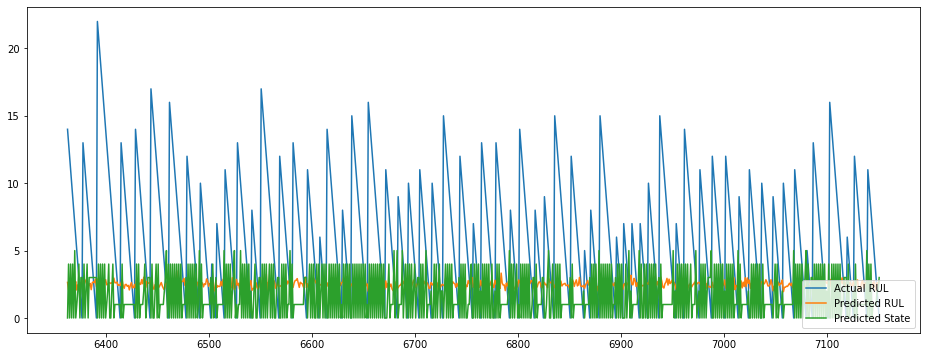

In [89]:
#plot graph for validation set
plt.figure(figsize=(16, 6))
plt.plot(valTime,valRUL) #plot actual RUL
plt.plot(valTime,valPredictedRUL2) #plot predicted RUL
plt.plot(valTime,valPredictedStates2) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

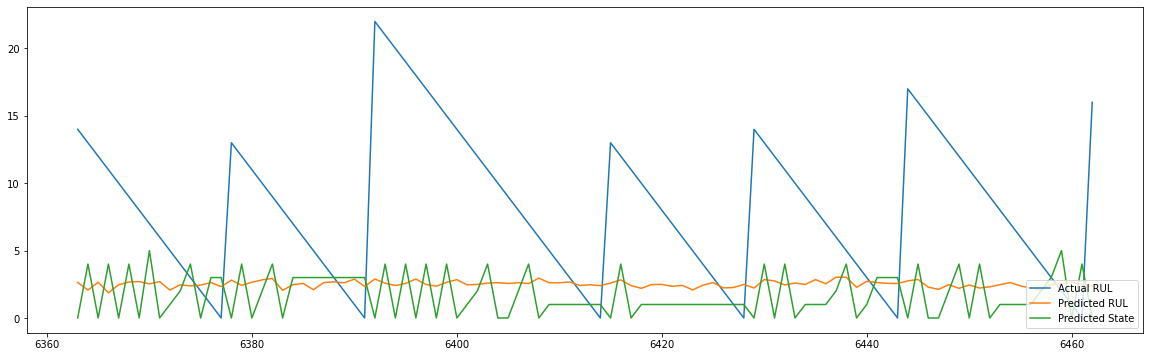

In [90]:
#plot graph for validation set
plt.figure(figsize=(20, 6))
plt.plot(valTime[:100],valRUL[:100]) #plot actual RUL
plt.plot(valTime[:100],valPredictedRUL2[:100]) #plot predicted RUL
plt.plot(valTime[:100],valPredictedStates2[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

### Model 3 No fixed parameters

In [91]:
hmmModel3 = GMMHMM(n_components=6, n_mix=2, covariance_type='diag', algorithm='viterbi', random_state=42, n_iter=300, params='stmcw', init_params='smcw')

In [92]:
#initialise transition matrix 
hmmModel3.transmat_ = initial_transmat

In [93]:
hmmModel3.fit(X=train_readings_format, lengths=train_length)

GMMHMM(covars_prior=array([[[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]],

       [[-1.5, -1.5, -1.5, -1.5],
        [-1.5, -1.5, -1.5, -1.5]]]),
       covars_weight=array([[[0., 0., 0., 0.],
        [0., 0., 0....
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]]]),
       means_weight=array([[0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.],
       [0., 0.]]),
       n_components=6, n_iter=300, n_mix=2, random_state=42,
     

In [94]:
hmmModel3.startprob_

array([0.01886932, 0.94495911, 0.01397012, 0.00628781, 0.00643675,
       0.00947689])

In [95]:
hmmModel3.transmat_

array([[0.25175663, 0.20999102, 0.11231432, 0.10034711, 0.26151872,
        0.0640722 ],
       [0.        , 0.83622377, 0.01786022, 0.02742843, 0.09645185,
        0.02203573],
       [0.        , 0.        , 0.17873501, 0.24275816, 0.47373507,
        0.10477175],
       [0.        , 0.        , 0.        , 0.20463095, 0.61252476,
        0.18284429],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [96]:
hmmModel3.weights_

array([[0.85578898, 0.14421102],
       [0.04453492, 0.95546508],
       [0.55088768, 0.44911232],
       [0.06853884, 0.93146116],
       [0.29423844, 0.70576156],
       [0.80325133, 0.19674867]])

In [97]:
hmmModel3.means_

array([[[0.44944493, 0.63877484, 0.21748377, 0.24283463],
        [0.41661   , 0.50268287, 0.21319444, 0.39184771]],

       [[0.35991725, 0.63666107, 0.21551361, 0.50524005],
        [0.35840359, 0.63913846, 0.21564848, 0.25093832]],

       [[0.38236244, 0.62750967, 0.46314947, 0.31468267],
        [0.35728964, 0.64002462, 0.21409948, 0.5570621 ]],

       [[0.60164736, 0.38819411, 0.21170673, 0.25571467],
        [0.35709526, 0.4984971 , 0.21452037, 0.24291167]],

       [[0.36093383, 0.37999296, 0.21605151, 0.25043005],
        [0.36573824, 0.63404968, 0.21590529, 0.23804023]],

       [[0.358031  , 0.64223877, 0.46835384, 0.24654278],
        [0.43612914, 0.53839026, 0.48929951, 0.24169658]]])

In [98]:
hmmModel3.covars_

array([[[0.01029553, 0.00093119, 0.00058937, 0.0008374 ],
        [0.01123481, 0.02091817, 0.00067423, 0.02414877]],

       [[0.00117781, 0.00095048, 0.00059968, 0.00773262],
        [0.00099179, 0.00100506, 0.00055795, 0.00097297]],

       [[0.00305839, 0.00231411, 0.00911041, 0.01479065],
        [0.0007994 , 0.00092373, 0.00038853, 0.00080503]],

       [[0.00205038, 0.00165252, 0.00038222, 0.00093791],
        [0.00093963, 0.0135546 , 0.00060379, 0.00081192]],

       [[0.00111842, 0.0009573 , 0.00058975, 0.00090349],
        [0.00071121, 0.00117208, 0.00059056, 0.00076712]],

       [[0.00106351, 0.00090598, 0.00511819, 0.00085315],
        [0.01177318, 0.01589167, 0.01102611, 0.00078207]]])

In [99]:
hmmModel3.monitor_.converged

True

In [100]:
trainPredictedStates3 = hmmModel3.predict(train_readings_format, lengths=train_length)

In [101]:
trainEndPredictedStates3 = findPredictedStateByIndex(trainPredictedStates3, trainEndIndexes)
Counter(trainEndPredictedStates3)

Counter({5: 66, 0: 178, 4: 169, 2: 62, 3: 29, 1: 30})

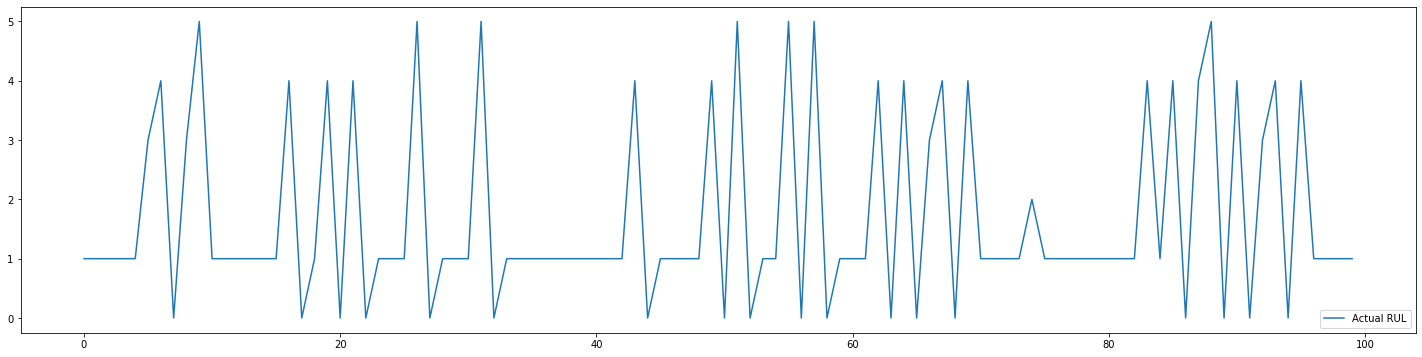

In [102]:
#plot graph for training set
plt.figure(figsize=(25, 6))
plt.plot(trainTime[:100],trainPredictedStates3[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

In [103]:
#Assume fail state is state 4 and 5
#training set predictions 
transitionMatrix3 = hmmModel3.transmat_
possibleStates = [0,1,2,3,4,5]
trainPredictedRUL3 = rulPredictor(hmmModel3, train_readings_format, transitionMatrix3, possibleStates, 100, 3)
trainScore3 = math.sqrt(mean_squared_error(trainRUL, trainPredictedRUL3))
print("Root mean squared error of training set is %f" % (trainScore3))

At 0 predicted RUL is 5.710000
At 1 predicted RUL is 7.590000
At 2 predicted RUL is 6.610000
At 3 predicted RUL is 8.650000
At 4 predicted RUL is 6.100000
At 5 predicted RUL is 6.360000
At 6 predicted RUL is 5.940000
At 7 predicted RUL is 5.500000
At 8 predicted RUL is 4.880000
At 9 predicted RUL is 4.980000
At 10 predicted RUL is 6.500000
At 11 predicted RUL is 6.740000
At 12 predicted RUL is 6.660000
At 13 predicted RUL is 6.540000
At 14 predicted RUL is 6.790000
At 15 predicted RUL is 5.790000
At 16 predicted RUL is 6.280000
At 17 predicted RUL is 4.340000
At 18 predicted RUL is 6.600000
At 19 predicted RUL is 5.180000
At 20 predicted RUL is 6.530000
At 21 predicted RUL is 3.350000
At 22 predicted RUL is 3.710000
At 23 predicted RUL is 7.330000
At 24 predicted RUL is 6.500000
At 25 predicted RUL is 7.050000
At 26 predicted RUL is 4.230000
At 27 predicted RUL is 7.590000
At 28 predicted RUL is 5.250000
At 29 predicted RUL is 5.590000
At 30 predicted RUL is 5.850000
At 31 predicted RU

At 255 predicted RUL is 3.030000
At 256 predicted RUL is 7.260000
At 257 predicted RUL is 6.980000
At 258 predicted RUL is 6.100000
At 259 predicted RUL is 6.820000
At 260 predicted RUL is 3.410000
At 261 predicted RUL is 6.070000
At 262 predicted RUL is 1.320000
At 263 predicted RUL is 6.480000
At 264 predicted RUL is 6.390000
At 265 predicted RUL is 6.000000
At 266 predicted RUL is 6.990000
At 267 predicted RUL is 6.310000
At 268 predicted RUL is 6.200000
At 269 predicted RUL is 5.900000
At 270 predicted RUL is 6.360000
At 271 predicted RUL is 5.110000
At 272 predicted RUL is 5.710000
At 273 predicted RUL is 5.800000
At 274 predicted RUL is 6.570000
At 275 predicted RUL is 5.940000
At 276 predicted RUL is 6.420000
At 277 predicted RUL is 6.840000
At 278 predicted RUL is 6.810000
At 279 predicted RUL is 4.910000
At 280 predicted RUL is 4.560000
At 281 predicted RUL is 6.900000
At 282 predicted RUL is 7.120000
At 283 predicted RUL is 6.920000
At 284 predicted RUL is 6.690000
At 285 pre

At 752 predicted RUL is 7.130000
At 753 predicted RUL is 4.350000
At 754 predicted RUL is 3.130000
At 755 predicted RUL is 3.690000
At 756 predicted RUL is 5.610000
At 757 predicted RUL is 3.280000
At 758 predicted RUL is 1.240000
At 759 predicted RUL is 7.230000
At 760 predicted RUL is 4.130000
At 761 predicted RUL is 6.660000
At 762 predicted RUL is 5.790000
At 763 predicted RUL is 7.370000
At 764 predicted RUL is 6.810000
At 765 predicted RUL is 6.270000
At 766 predicted RUL is 6.690000
At 767 predicted RUL is 5.840000
At 768 predicted RUL is 6.610000
At 769 predicted RUL is 7.210000
At 770 predicted RUL is 3.590000
At 771 predicted RUL is 4.720000
At 772 predicted RUL is 6.490000
At 773 predicted RUL is 1.620000
At 774 predicted RUL is 5.150000
At 775 predicted RUL is 5.840000
At 776 predicted RUL is 6.840000
At 777 predicted RUL is 6.770000
At 778 predicted RUL is 7.040000
At 779 predicted RUL is 6.380000
At 780 predicted RUL is 4.280000
At 781 predicted RUL is 3.530000
At 782 pre

At 1005 predicted RUL is 3.740000
At 1006 predicted RUL is 6.200000
At 1007 predicted RUL is 4.480000
At 1008 predicted RUL is 6.560000
At 1009 predicted RUL is 7.140000
At 1010 predicted RUL is 6.890000
At 1011 predicted RUL is 6.320000
At 1012 predicted RUL is 5.850000
At 1013 predicted RUL is 6.450000
At 1014 predicted RUL is 6.200000
At 1015 predicted RUL is 4.290000
At 1016 predicted RUL is 6.310000
At 1017 predicted RUL is 6.180000
At 1018 predicted RUL is 1.220000
At 1019 predicted RUL is 6.290000
At 1020 predicted RUL is 6.070000
At 1021 predicted RUL is 5.750000
At 1022 predicted RUL is 6.810000
At 1023 predicted RUL is 5.720000
At 1024 predicted RUL is 6.710000
At 1025 predicted RUL is 6.830000
At 1026 predicted RUL is 6.980000
At 1027 predicted RUL is 4.780000
At 1028 predicted RUL is 7.360000
At 1029 predicted RUL is 5.760000
At 1030 predicted RUL is 6.900000
At 1031 predicted RUL is 6.390000
At 1032 predicted RUL is 6.420000
At 1033 predicted RUL is 6.690000
At 1034 predic

At 1250 predicted RUL is 4.090000
At 1251 predicted RUL is 5.960000
At 1252 predicted RUL is 6.730000
At 1253 predicted RUL is 6.870000
At 1254 predicted RUL is 6.760000
At 1255 predicted RUL is 6.120000
At 1256 predicted RUL is 7.560000
At 1257 predicted RUL is 7.590000
At 1258 predicted RUL is 6.020000
At 1259 predicted RUL is 3.640000
At 1260 predicted RUL is 6.220000
At 1261 predicted RUL is 3.330000
At 1262 predicted RUL is 5.880000
At 1263 predicted RUL is 1.260000
At 1264 predicted RUL is 6.740000
At 1265 predicted RUL is 6.380000
At 1266 predicted RUL is 5.310000
At 1267 predicted RUL is 7.020000
At 1268 predicted RUL is 5.930000
At 1269 predicted RUL is 7.300000
At 1270 predicted RUL is 5.950000
At 1271 predicted RUL is 4.600000
At 1272 predicted RUL is 6.640000
At 1273 predicted RUL is 5.880000
At 1274 predicted RUL is 6.690000
At 1275 predicted RUL is 6.720000
At 1276 predicted RUL is 6.160000
At 1277 predicted RUL is 6.520000
At 1278 predicted RUL is 6.170000
At 1279 predic

At 1493 predicted RUL is 6.390000
At 1494 predicted RUL is 6.270000
At 1495 predicted RUL is 7.270000
At 1496 predicted RUL is 7.270000
At 1497 predicted RUL is 5.790000
At 1498 predicted RUL is 6.370000
At 1499 predicted RUL is 6.520000
At 1500 predicted RUL is 6.550000
At 1501 predicted RUL is 6.800000
At 1502 predicted RUL is 5.420000
At 1503 predicted RUL is 6.060000
At 1504 predicted RUL is 5.800000
At 1505 predicted RUL is 6.380000
At 1506 predicted RUL is 5.550000
At 1507 predicted RUL is 3.290000
At 1508 predicted RUL is 5.770000
At 1509 predicted RUL is 6.030000
At 1510 predicted RUL is 6.610000
At 1511 predicted RUL is 5.940000
At 1512 predicted RUL is 7.200000
At 1513 predicted RUL is 7.100000
At 1514 predicted RUL is 6.760000
At 1515 predicted RUL is 6.780000
At 1516 predicted RUL is 5.950000
At 1517 predicted RUL is 6.920000
At 1518 predicted RUL is 6.170000
At 1519 predicted RUL is 6.260000
At 1520 predicted RUL is 5.810000
At 1521 predicted RUL is 6.160000
At 1522 predic

At 1736 predicted RUL is 6.980000
At 1737 predicted RUL is 1.550000
At 1738 predicted RUL is 3.980000
At 1739 predicted RUL is 6.000000
At 1740 predicted RUL is 7.100000
At 1741 predicted RUL is 6.660000
At 1742 predicted RUL is 7.800000
At 1743 predicted RUL is 5.720000
At 1744 predicted RUL is 7.090000
At 1745 predicted RUL is 6.200000
At 1746 predicted RUL is 6.680000
At 1747 predicted RUL is 7.230000
At 1748 predicted RUL is 1.350000
At 1749 predicted RUL is 4.830000
At 1750 predicted RUL is 6.400000
At 1751 predicted RUL is 6.500000
At 1752 predicted RUL is 6.020000
At 1753 predicted RUL is 3.150000
At 1754 predicted RUL is 6.770000
At 1755 predicted RUL is 6.510000
At 1756 predicted RUL is 6.030000
At 1757 predicted RUL is 7.270000
At 1758 predicted RUL is 6.460000
At 1759 predicted RUL is 3.450000
At 1760 predicted RUL is 1.240000
At 1761 predicted RUL is 6.010000
At 1762 predicted RUL is 6.020000
At 1763 predicted RUL is 4.190000
At 1764 predicted RUL is 6.050000
At 1765 predic

At 1980 predicted RUL is 6.740000
At 1981 predicted RUL is 5.320000
At 1982 predicted RUL is 6.850000
At 1983 predicted RUL is 6.230000
At 1984 predicted RUL is 7.210000
At 1985 predicted RUL is 6.110000
At 1986 predicted RUL is 6.250000
At 1987 predicted RUL is 3.960000
At 1988 predicted RUL is 7.840000
At 1989 predicted RUL is 1.280000
At 1990 predicted RUL is 6.520000
At 1991 predicted RUL is 6.430000
At 1992 predicted RUL is 5.750000
At 1993 predicted RUL is 6.980000
At 1994 predicted RUL is 3.640000
At 1995 predicted RUL is 6.470000
At 1996 predicted RUL is 6.100000
At 1997 predicted RUL is 6.440000
At 1998 predicted RUL is 6.530000
At 1999 predicted RUL is 6.760000
At 2000 predicted RUL is 6.380000
At 2001 predicted RUL is 6.130000
At 2002 predicted RUL is 5.740000
At 2003 predicted RUL is 6.210000
At 2004 predicted RUL is 5.860000
At 2005 predicted RUL is 6.440000
At 2006 predicted RUL is 5.340000
At 2007 predicted RUL is 6.950000
At 2008 predicted RUL is 3.960000
At 2009 predic

At 2226 predicted RUL is 6.320000
At 2227 predicted RUL is 7.000000
At 2228 predicted RUL is 6.310000
At 2229 predicted RUL is 7.710000
At 2230 predicted RUL is 6.320000
At 2231 predicted RUL is 6.770000
At 2232 predicted RUL is 6.000000
At 2233 predicted RUL is 6.900000
At 2234 predicted RUL is 5.200000
At 2235 predicted RUL is 6.510000
At 2236 predicted RUL is 3.350000
At 2237 predicted RUL is 6.300000
At 2238 predicted RUL is 6.300000
At 2239 predicted RUL is 6.380000
At 2240 predicted RUL is 6.880000
At 2241 predicted RUL is 5.430000
At 2242 predicted RUL is 6.210000
At 2243 predicted RUL is 6.470000
At 2244 predicted RUL is 4.090000
At 2245 predicted RUL is 4.240000
At 2246 predicted RUL is 4.240000
At 2247 predicted RUL is 5.500000
At 2248 predicted RUL is 7.010000
At 2249 predicted RUL is 1.290000
At 2250 predicted RUL is 6.250000
At 2251 predicted RUL is 7.390000
At 2252 predicted RUL is 7.260000
At 2253 predicted RUL is 7.880000
At 2254 predicted RUL is 7.060000
At 2255 predic

At 2474 predicted RUL is 6.840000
At 2475 predicted RUL is 6.440000
At 2476 predicted RUL is 6.200000
At 2477 predicted RUL is 6.710000
At 2478 predicted RUL is 6.110000
At 2479 predicted RUL is 6.800000
At 2480 predicted RUL is 6.400000
At 2481 predicted RUL is 5.830000
At 2482 predicted RUL is 4.410000
At 2483 predicted RUL is 3.670000
At 2484 predicted RUL is 7.560000
At 2485 predicted RUL is 6.620000
At 2486 predicted RUL is 6.660000
At 2487 predicted RUL is 5.940000
At 2488 predicted RUL is 6.790000
At 2489 predicted RUL is 6.340000
At 2490 predicted RUL is 6.600000
At 2491 predicted RUL is 6.510000
At 2492 predicted RUL is 7.610000
At 2493 predicted RUL is 6.720000
At 2494 predicted RUL is 4.470000
At 2495 predicted RUL is 6.860000
At 2496 predicted RUL is 5.920000
At 2497 predicted RUL is 6.000000
At 2498 predicted RUL is 6.920000
At 2499 predicted RUL is 6.130000
At 2500 predicted RUL is 6.830000
At 2501 predicted RUL is 4.130000
At 2502 predicted RUL is 5.420000
At 2503 predic

At 2716 predicted RUL is 6.550000
At 2717 predicted RUL is 7.340000
At 2718 predicted RUL is 6.310000
At 2719 predicted RUL is 6.790000
At 2720 predicted RUL is 6.200000
At 2721 predicted RUL is 5.220000
At 2722 predicted RUL is 5.380000
At 2723 predicted RUL is 6.530000
At 2724 predicted RUL is 3.550000
At 2725 predicted RUL is 6.090000
At 2726 predicted RUL is 1.260000
At 2727 predicted RUL is 1.190000
At 2728 predicted RUL is 5.720000
At 2729 predicted RUL is 5.190000
At 2730 predicted RUL is 6.060000
At 2731 predicted RUL is 5.820000
At 2732 predicted RUL is 7.270000
At 2733 predicted RUL is 7.240000
At 2734 predicted RUL is 6.810000
At 2735 predicted RUL is 4.070000
At 2736 predicted RUL is 4.000000
At 2737 predicted RUL is 6.030000
At 2738 predicted RUL is 5.720000
At 2739 predicted RUL is 7.200000
At 2740 predicted RUL is 6.370000
At 2741 predicted RUL is 7.260000
At 2742 predicted RUL is 6.510000
At 2743 predicted RUL is 6.980000
At 2744 predicted RUL is 6.430000
At 2745 predic

At 2963 predicted RUL is 5.940000
At 2964 predicted RUL is 6.530000
At 2965 predicted RUL is 6.840000
At 2966 predicted RUL is 6.360000
At 2967 predicted RUL is 6.660000
At 2968 predicted RUL is 6.610000
At 2969 predicted RUL is 6.920000
At 2970 predicted RUL is 6.380000
At 2971 predicted RUL is 7.330000
At 2972 predicted RUL is 4.640000
At 2973 predicted RUL is 3.350000
At 2974 predicted RUL is 6.040000
At 2975 predicted RUL is 5.400000
At 2976 predicted RUL is 6.610000
At 2977 predicted RUL is 3.360000
At 2978 predicted RUL is 6.380000
At 2979 predicted RUL is 1.180000
At 2980 predicted RUL is 5.050000
At 2981 predicted RUL is 3.970000
At 2982 predicted RUL is 5.910000
At 2983 predicted RUL is 6.150000
At 2984 predicted RUL is 6.250000
At 2985 predicted RUL is 5.850000
At 2986 predicted RUL is 5.930000
At 2987 predicted RUL is 6.140000
At 2988 predicted RUL is 6.240000
At 2989 predicted RUL is 6.290000
At 2990 predicted RUL is 6.780000
At 2991 predicted RUL is 6.420000
At 2992 predic

At 3207 predicted RUL is 6.110000
At 3208 predicted RUL is 6.710000
At 3209 predicted RUL is 6.930000
At 3210 predicted RUL is 6.620000
At 3211 predicted RUL is 3.340000
At 3212 predicted RUL is 8.120000
At 3213 predicted RUL is 6.500000
At 3214 predicted RUL is 4.320000
At 3215 predicted RUL is 4.690000
At 3216 predicted RUL is 6.750000
At 3217 predicted RUL is 6.180000
At 3218 predicted RUL is 6.720000
At 3219 predicted RUL is 6.090000
At 3220 predicted RUL is 7.380000
At 3221 predicted RUL is 5.960000
At 3222 predicted RUL is 7.560000
At 3223 predicted RUL is 5.650000
At 3224 predicted RUL is 4.620000
At 3225 predicted RUL is 5.170000
At 3226 predicted RUL is 3.980000
At 3227 predicted RUL is 4.810000
At 3228 predicted RUL is 5.990000
At 3229 predicted RUL is 6.590000
At 3230 predicted RUL is 6.930000
At 3231 predicted RUL is 6.930000
At 3232 predicted RUL is 1.550000
At 3233 predicted RUL is 6.200000
At 3234 predicted RUL is 5.860000
At 3235 predicted RUL is 7.310000
At 3236 predic

At 3689 predicted RUL is 6.000000
At 3690 predicted RUL is 6.280000
At 3691 predicted RUL is 6.650000
At 3692 predicted RUL is 6.880000
At 3693 predicted RUL is 5.890000
At 3694 predicted RUL is 5.780000
At 3695 predicted RUL is 6.470000
At 3696 predicted RUL is 6.550000
At 3697 predicted RUL is 5.530000
At 3698 predicted RUL is 6.550000
At 3699 predicted RUL is 3.200000
At 3700 predicted RUL is 6.820000
At 3701 predicted RUL is 6.700000
At 3702 predicted RUL is 3.750000
At 3703 predicted RUL is 1.470000
At 3704 predicted RUL is 5.830000
At 3705 predicted RUL is 5.940000
At 3706 predicted RUL is 1.270000
At 3707 predicted RUL is 3.290000
At 3708 predicted RUL is 6.450000
At 3709 predicted RUL is 7.120000
At 3710 predicted RUL is 5.460000
At 3711 predicted RUL is 6.490000
At 3712 predicted RUL is 6.190000
At 3713 predicted RUL is 6.310000
At 3714 predicted RUL is 6.840000
At 3715 predicted RUL is 6.260000
At 3716 predicted RUL is 6.430000
At 3717 predicted RUL is 6.510000
At 3718 predic

At 3932 predicted RUL is 6.140000
At 3933 predicted RUL is 1.270000
At 3934 predicted RUL is 2.890000
At 3935 predicted RUL is 4.440000
At 3936 predicted RUL is 7.220000
At 3937 predicted RUL is 5.530000
At 3938 predicted RUL is 7.130000
At 3939 predicted RUL is 5.990000
At 3940 predicted RUL is 1.170000
At 3941 predicted RUL is 6.070000
At 3942 predicted RUL is 6.530000
At 3943 predicted RUL is 6.170000
At 3944 predicted RUL is 6.510000
At 3945 predicted RUL is 7.180000
At 3946 predicted RUL is 6.820000
At 3947 predicted RUL is 2.740000
At 3948 predicted RUL is 4.510000
At 3949 predicted RUL is 6.230000
At 3950 predicted RUL is 3.520000
At 3951 predicted RUL is 6.370000
At 3952 predicted RUL is 6.220000
At 3953 predicted RUL is 5.830000
At 3954 predicted RUL is 6.330000
At 3955 predicted RUL is 7.400000
At 3956 predicted RUL is 5.910000
At 3957 predicted RUL is 6.520000
At 3958 predicted RUL is 6.110000
At 3959 predicted RUL is 7.100000
At 3960 predicted RUL is 4.010000
At 3961 predic

At 4182 predicted RUL is 6.540000
At 4183 predicted RUL is 8.050000
At 4184 predicted RUL is 7.170000
At 4185 predicted RUL is 6.820000
At 4186 predicted RUL is 6.740000
At 4187 predicted RUL is 6.600000
At 4188 predicted RUL is 4.480000
At 4189 predicted RUL is 7.160000
At 4190 predicted RUL is 1.260000
At 4191 predicted RUL is 6.290000
At 4192 predicted RUL is 6.270000
At 4193 predicted RUL is 7.950000
At 4194 predicted RUL is 5.620000
At 4195 predicted RUL is 7.050000
At 4196 predicted RUL is 7.190000
At 4197 predicted RUL is 5.670000
At 4198 predicted RUL is 6.760000
At 4199 predicted RUL is 4.340000
At 4200 predicted RUL is 1.230000
At 4201 predicted RUL is 6.100000
At 4202 predicted RUL is 3.760000
At 4203 predicted RUL is 7.830000
At 4204 predicted RUL is 6.420000
At 4205 predicted RUL is 6.550000
At 4206 predicted RUL is 7.040000
At 4207 predicted RUL is 6.220000
At 4208 predicted RUL is 6.750000
At 4209 predicted RUL is 5.840000
At 4210 predicted RUL is 5.580000
At 4211 predic

At 4425 predicted RUL is 6.970000
At 4426 predicted RUL is 1.270000
At 4427 predicted RUL is 5.590000
At 4428 predicted RUL is 6.530000
At 4429 predicted RUL is 5.310000
At 4430 predicted RUL is 3.490000
At 4431 predicted RUL is 4.340000
At 4432 predicted RUL is 6.990000
At 4433 predicted RUL is 3.650000
At 4434 predicted RUL is 7.060000
At 4435 predicted RUL is 6.030000
At 4436 predicted RUL is 7.220000
At 4437 predicted RUL is 6.140000
At 4438 predicted RUL is 5.750000
At 4439 predicted RUL is 6.500000
At 4440 predicted RUL is 6.530000
At 4441 predicted RUL is 6.930000
At 4442 predicted RUL is 5.380000
At 4443 predicted RUL is 4.140000
At 4444 predicted RUL is 6.800000
At 4445 predicted RUL is 3.540000
At 4446 predicted RUL is 6.630000
At 4447 predicted RUL is 7.550000
At 4448 predicted RUL is 6.930000
At 4449 predicted RUL is 6.070000
At 4450 predicted RUL is 7.400000
At 4451 predicted RUL is 7.300000
At 4452 predicted RUL is 5.690000
At 4453 predicted RUL is 6.470000
At 4454 predic

At 4669 predicted RUL is 5.970000
At 4670 predicted RUL is 7.240000
At 4671 predicted RUL is 6.170000
At 4672 predicted RUL is 7.940000
At 4673 predicted RUL is 5.430000
At 4674 predicted RUL is 7.610000
At 4675 predicted RUL is 3.740000
At 4676 predicted RUL is 6.570000
At 4677 predicted RUL is 6.090000
At 4678 predicted RUL is 5.820000
At 4679 predicted RUL is 5.830000
At 4680 predicted RUL is 6.310000
At 4681 predicted RUL is 6.500000
At 4682 predicted RUL is 7.560000
At 4683 predicted RUL is 4.810000
At 4684 predicted RUL is 4.290000
At 4685 predicted RUL is 8.320000
At 4686 predicted RUL is 1.310000
At 4687 predicted RUL is 7.100000
At 4688 predicted RUL is 6.370000
At 4689 predicted RUL is 6.330000
At 4690 predicted RUL is 5.790000
At 4691 predicted RUL is 7.000000
At 4692 predicted RUL is 6.470000
At 4693 predicted RUL is 5.830000
At 4694 predicted RUL is 4.020000
At 4695 predicted RUL is 3.700000
At 4696 predicted RUL is 7.910000
At 4697 predicted RUL is 6.360000
At 4698 predic

At 5153 predicted RUL is 6.070000
At 5154 predicted RUL is 6.730000
At 5155 predicted RUL is 7.130000
At 5156 predicted RUL is 6.890000
At 5157 predicted RUL is 4.910000
At 5158 predicted RUL is 7.100000
At 5159 predicted RUL is 4.110000
At 5160 predicted RUL is 7.080000
At 5161 predicted RUL is 7.480000
At 5162 predicted RUL is 5.710000
At 5163 predicted RUL is 7.150000
At 5164 predicted RUL is 6.300000
At 5165 predicted RUL is 6.460000
At 5166 predicted RUL is 6.570000
At 5167 predicted RUL is 6.610000
At 5168 predicted RUL is 6.450000
At 5169 predicted RUL is 4.650000
At 5170 predicted RUL is 6.010000
At 5171 predicted RUL is 6.150000
At 5172 predicted RUL is 6.740000
At 5173 predicted RUL is 7.380000
At 5174 predicted RUL is 6.770000
At 5175 predicted RUL is 7.060000
At 5176 predicted RUL is 5.840000
At 5177 predicted RUL is 6.080000
At 5178 predicted RUL is 6.340000
At 5179 predicted RUL is 6.240000
At 5180 predicted RUL is 5.980000
At 5181 predicted RUL is 6.890000
At 5182 predic

At 5396 predicted RUL is 6.510000
At 5397 predicted RUL is 6.170000
At 5398 predicted RUL is 5.850000
At 5399 predicted RUL is 6.370000
At 5400 predicted RUL is 6.010000
At 5401 predicted RUL is 7.530000
At 5402 predicted RUL is 5.420000
At 5403 predicted RUL is 6.530000
At 5404 predicted RUL is 5.330000
At 5405 predicted RUL is 5.850000
At 5406 predicted RUL is 6.520000
At 5407 predicted RUL is 6.100000
At 5408 predicted RUL is 3.890000
At 5409 predicted RUL is 5.630000
At 5410 predicted RUL is 5.960000
At 5411 predicted RUL is 7.280000
At 5412 predicted RUL is 6.940000
At 5413 predicted RUL is 6.490000
At 5414 predicted RUL is 6.510000
At 5415 predicted RUL is 7.050000
At 5416 predicted RUL is 5.590000
At 5417 predicted RUL is 4.110000
At 5418 predicted RUL is 3.470000
At 5419 predicted RUL is 6.900000
At 5420 predicted RUL is 6.340000
At 5421 predicted RUL is 5.850000
At 5422 predicted RUL is 7.340000
At 5423 predicted RUL is 5.780000
At 5424 predicted RUL is 6.840000
At 5425 predic

At 5640 predicted RUL is 7.690000
At 5641 predicted RUL is 6.430000
At 5642 predicted RUL is 6.460000
At 5643 predicted RUL is 5.890000
At 5644 predicted RUL is 7.790000
At 5645 predicted RUL is 5.460000
At 5646 predicted RUL is 6.120000
At 5647 predicted RUL is 7.030000
At 5648 predicted RUL is 6.400000
At 5649 predicted RUL is 6.530000
At 5650 predicted RUL is 7.400000
At 5651 predicted RUL is 5.180000
At 5652 predicted RUL is 7.010000
At 5653 predicted RUL is 4.910000
At 5654 predicted RUL is 6.890000
At 5655 predicted RUL is 4.040000
At 5656 predicted RUL is 6.710000
At 5657 predicted RUL is 6.030000
At 5658 predicted RUL is 6.260000
At 5659 predicted RUL is 6.320000
At 5660 predicted RUL is 6.490000
At 5661 predicted RUL is 6.770000
At 5662 predicted RUL is 6.450000
At 5663 predicted RUL is 6.810000
At 5664 predicted RUL is 6.630000
At 5665 predicted RUL is 1.180000
At 5666 predicted RUL is 6.740000
At 5667 predicted RUL is 6.960000
At 5668 predicted RUL is 6.180000
At 5669 predic

At 5883 predicted RUL is 7.070000
At 5884 predicted RUL is 1.490000
At 5885 predicted RUL is 6.200000
At 5886 predicted RUL is 6.020000
At 5887 predicted RUL is 1.280000
At 5888 predicted RUL is 7.240000
At 5889 predicted RUL is 6.830000
At 5890 predicted RUL is 6.740000
At 5891 predicted RUL is 6.590000
At 5892 predicted RUL is 6.150000
At 5893 predicted RUL is 7.720000
At 5894 predicted RUL is 5.030000
At 5895 predicted RUL is 7.620000
At 5896 predicted RUL is 4.890000
At 5897 predicted RUL is 7.160000
At 5898 predicted RUL is 6.530000
At 5899 predicted RUL is 6.640000
At 5900 predicted RUL is 6.450000
At 5901 predicted RUL is 6.000000
At 5902 predicted RUL is 7.180000
At 5903 predicted RUL is 6.340000
At 5904 predicted RUL is 6.550000
At 5905 predicted RUL is 3.790000
At 5906 predicted RUL is 5.290000
At 5907 predicted RUL is 6.210000
At 5908 predicted RUL is 7.290000
At 5909 predicted RUL is 5.560000
At 5910 predicted RUL is 4.170000
At 5911 predicted RUL is 6.940000
At 5912 predic

In [104]:
trainR2Score3 = r2_score(trainRUL, trainPredictedRUL3)
print("R2 Score of training set is %f" % (trainR2Score3))

R2 Score of training set is 0.062555


In [105]:
trainSscore3 = findSscore(trainRUL, trainPredictedRUL3)
print("S Score of validation set is %f" % (trainSscore3))

S Score of validation set is 9113.934807


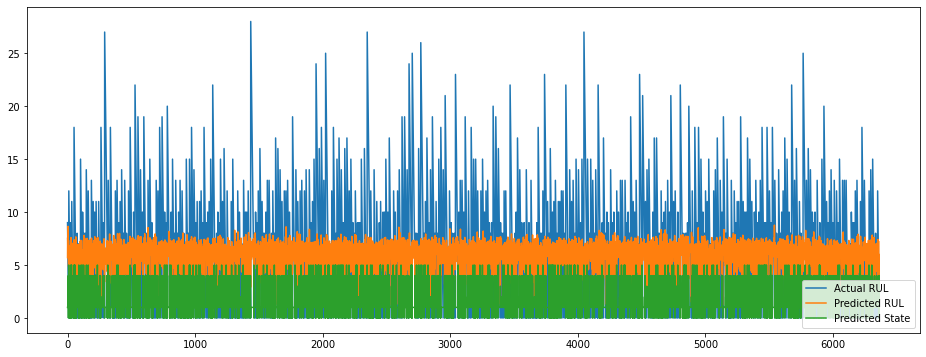

In [106]:
#plot graph for training set
plt.figure(figsize=(16, 6))
plt.plot(trainTime,trainRUL) #plot actual RUL
plt.plot(trainTime,trainPredictedRUL3) #plot predicted RUL
plt.plot(trainTime,trainPredictedStates3) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

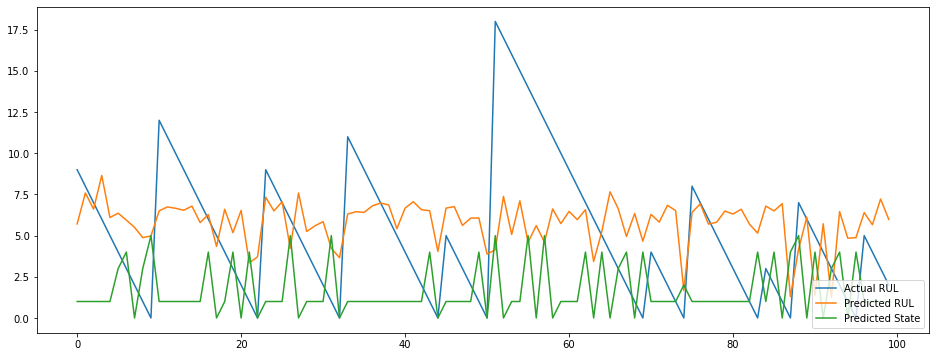

In [107]:
#plot graph for training set
plt.figure(figsize=(16, 6))
plt.plot(trainTime[:100],trainRUL[:100]) #plot actual RUL
plt.plot(trainTime[:100],trainPredictedRUL3[:100]) #plot predicted RUL
plt.plot(trainTime[:100],trainPredictedStates3[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

In [108]:
valPredictedStates3 = hmmModel3.predict(val_readings_format, lengths=val_length)

In [109]:
#validation set predictions 
transitionMatrix3 = hmmModel3.transmat_
valPredictedRUL3 = rulPredictor(hmmModel3, val_readings_format, transitionMatrix3, possibleStates, 100, 3)
valScore3 = math.sqrt(mean_squared_error(valRUL, valPredictedRUL3))
print("Root mean squared error of training set is %f" % (valScore3))

At 0 predicted RUL is 6.880000
At 1 predicted RUL is 7.090000
At 2 predicted RUL is 6.240000
At 3 predicted RUL is 6.190000
At 4 predicted RUL is 7.190000
At 5 predicted RUL is 6.460000
At 6 predicted RUL is 6.680000
At 7 predicted RUL is 1.560000
At 8 predicted RUL is 1.230000
At 9 predicted RUL is 6.350000
At 10 predicted RUL is 6.530000
At 11 predicted RUL is 6.840000
At 12 predicted RUL is 6.200000
At 13 predicted RUL is 5.600000
At 14 predicted RUL is 4.740000
At 15 predicted RUL is 6.160000
At 16 predicted RUL is 7.790000
At 17 predicted RUL is 5.920000
At 18 predicted RUL is 6.000000
At 19 predicted RUL is 5.930000
At 20 predicted RUL is 5.940000
At 21 predicted RUL is 5.270000
At 22 predicted RUL is 3.830000
At 23 predicted RUL is 6.260000
At 24 predicted RUL is 7.310000
At 25 predicted RUL is 6.140000
At 26 predicted RUL is 4.490000
At 27 predicted RUL is 5.830000
At 28 predicted RUL is 3.410000
At 29 predicted RUL is 6.020000
At 30 predicted RUL is 6.980000
At 31 predicted RU

At 252 predicted RUL is 6.270000
At 253 predicted RUL is 6.920000
At 254 predicted RUL is 6.030000
At 255 predicted RUL is 6.040000
At 256 predicted RUL is 6.770000
At 257 predicted RUL is 5.560000
At 258 predicted RUL is 5.360000
At 259 predicted RUL is 6.440000
At 260 predicted RUL is 6.630000
At 261 predicted RUL is 6.590000
At 262 predicted RUL is 6.120000
At 263 predicted RUL is 7.030000
At 264 predicted RUL is 6.880000
At 265 predicted RUL is 3.220000
At 266 predicted RUL is 3.360000
At 267 predicted RUL is 6.540000
At 268 predicted RUL is 7.180000
At 269 predicted RUL is 6.350000
At 270 predicted RUL is 6.740000
At 271 predicted RUL is 7.320000
At 272 predicted RUL is 6.400000
At 273 predicted RUL is 6.000000
At 274 predicted RUL is 4.410000
At 275 predicted RUL is 6.520000
At 276 predicted RUL is 6.760000
At 277 predicted RUL is 6.800000
At 278 predicted RUL is 5.430000
At 279 predicted RUL is 6.670000
At 280 predicted RUL is 6.070000
At 281 predicted RUL is 6.200000
At 282 pre

At 503 predicted RUL is 6.850000
At 504 predicted RUL is 6.760000
At 505 predicted RUL is 3.210000
At 506 predicted RUL is 6.060000
At 507 predicted RUL is 1.250000
At 508 predicted RUL is 6.470000
At 509 predicted RUL is 6.410000
At 510 predicted RUL is 6.590000
At 511 predicted RUL is 6.240000
At 512 predicted RUL is 6.720000
At 513 predicted RUL is 1.260000
At 514 predicted RUL is 7.120000
At 515 predicted RUL is 6.630000
At 516 predicted RUL is 4.620000
At 517 predicted RUL is 7.070000
At 518 predicted RUL is 6.390000
At 519 predicted RUL is 6.800000
At 520 predicted RUL is 7.470000
At 521 predicted RUL is 6.800000
At 522 predicted RUL is 6.450000
At 523 predicted RUL is 6.130000
At 524 predicted RUL is 6.190000
At 525 predicted RUL is 5.480000
At 526 predicted RUL is 7.100000
At 527 predicted RUL is 7.350000
At 528 predicted RUL is 6.220000
At 529 predicted RUL is 6.200000
At 530 predicted RUL is 6.020000
At 531 predicted RUL is 5.880000
At 532 predicted RUL is 5.000000
At 533 pre

At 752 predicted RUL is 3.940000
At 753 predicted RUL is 6.740000
At 754 predicted RUL is 1.180000
At 755 predicted RUL is 7.290000
At 756 predicted RUL is 4.490000
At 757 predicted RUL is 6.770000
At 758 predicted RUL is 5.320000
At 759 predicted RUL is 6.420000
At 760 predicted RUL is 5.980000
At 761 predicted RUL is 6.470000
At 762 predicted RUL is 6.060000
At 763 predicted RUL is 6.400000
At 764 predicted RUL is 6.770000
At 765 predicted RUL is 5.770000
At 766 predicted RUL is 7.540000
At 767 predicted RUL is 7.010000
At 768 predicted RUL is 6.010000
At 769 predicted RUL is 7.130000
At 770 predicted RUL is 6.400000
At 771 predicted RUL is 5.580000
At 772 predicted RUL is 7.530000
At 773 predicted RUL is 6.800000
At 774 predicted RUL is 6.320000
At 775 predicted RUL is 3.400000
At 776 predicted RUL is 3.900000
At 777 predicted RUL is 6.420000
At 778 predicted RUL is 6.790000
At 779 predicted RUL is 5.960000
At 780 predicted RUL is 5.970000
At 781 predicted RUL is 6.840000
At 782 pre

In [110]:
valR2Score3 = r2_score(valRUL, valPredictedRUL3)
print("R2 Score of validation set is %f" % (valR2Score3))

R2 Score of validation set is 0.109418


In [111]:
valSscore3 = findSscore(valRUL, valPredictedRUL3)
print("S Score of validation set is %f" % (valSscore3))

S Score of validation set is 1077.637577


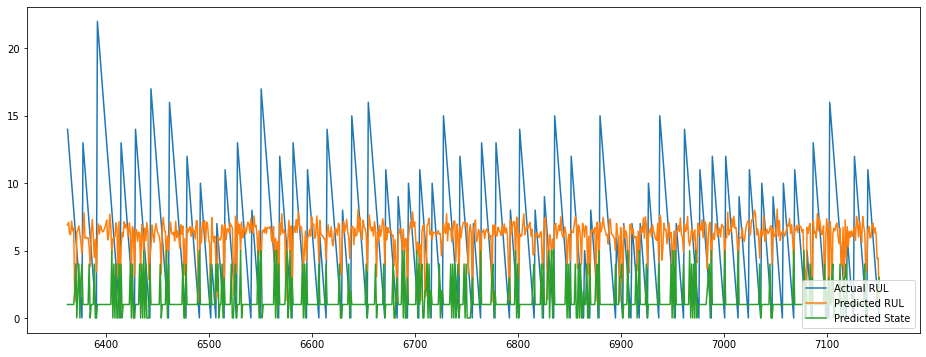

In [112]:
#plot graph for validation set
plt.figure(figsize=(16, 6))
plt.plot(valTime,valRUL) #plot actual RUL
plt.plot(valTime,valPredictedRUL3) #plot predicted RUL
plt.plot(valTime,valPredictedStates3) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()

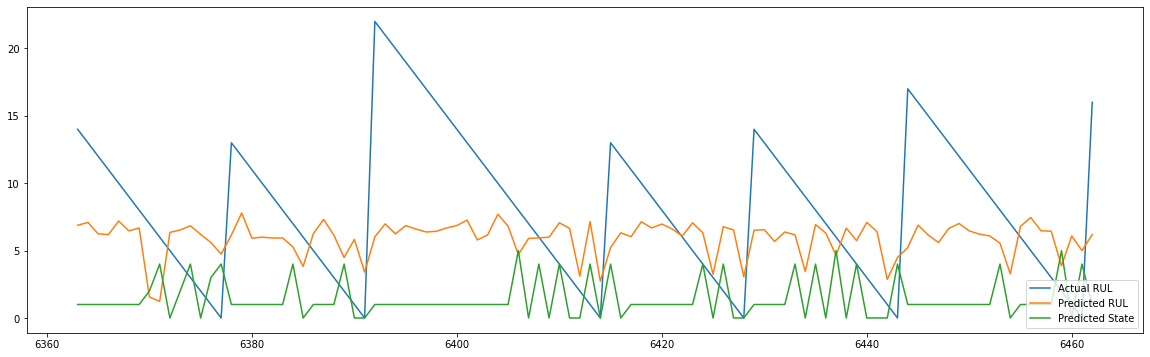

In [113]:
#plot graph for validation set
plt.figure(figsize=(20, 6))
plt.plot(valTime[:100],valRUL[:100]) #plot actual RUL
plt.plot(valTime[:100],valPredictedRUL3[:100]) #plot predicted RUL
plt.plot(valTime[:100],valPredictedStates3[:100]) #plot predicted machine states
plt.legend(['Actual RUL', 'Predicted RUL', 'Predicted State'], loc='lower right')
plt.show()